In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import gc 

pd.options.display.float_format = "{:.2f}".format

def type_mix(df: pd.DataFrame):
    return pd.Series({
        "n_numeric": int(df.select_dtypes(include=np.number).shape[1]),
        "n_categorical": int(df.select_dtypes(exclude=np.number).shape[1]),
        "n_bool": int(df.select_dtypes(include=["bool"]).shape[1]),
        "n_object": int(df.select_dtypes(include=["object"]).shape[1]),
    })

def key_check(df: pd.DataFrame, key_cols):
    out = {}
    for k in key_cols:
        if k in df.columns:
            out[f"{k}__exists"] = True
            out[f"{k}__unique_rows"] = df[k].is_unique
            out[f"{k}__nulls"] = int(df[k].isna().sum())
        else:
            out[f"{k}__exists"] = False
    return pd.Series(out)

def structural_summary(df: pd.DataFrame, name: str, key_cols=()):
    rows, cols = df.shape
    summary = pd.Series({
        "dataset": name,
        "rows": rows,
        "columns": cols,
        "avg_missing (%)": round(df.isna().mean().mean()*100, 2),
    })
    summary = pd.concat([summary, type_mix(df), key_check(df, key_cols)])
    return summary

In [99]:
def correlation_redundancy(df, threshold=0.8):
    """
    df: DataFrame
    threshold: correlation threshold
    """
    # Select numeric columns
    num_df = df.select_dtypes(include=[np.number]).copy()
    if num_df.empty:
        print("No numeric columns found.")
        return

    # Correlation matrix
    corr_matrix = num_df.corr().abs()

    # Heatmap of the correlation matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(
        corr_matrix,
        cmap="coolwarm",
        center=0,
        annot=False
    )
    plt.title("Correlation Matrix")
    plt.show()

    # Redundancy: exclude the diagonal (correlation with itself)
    corr_pairs = (
        corr_matrix
        .where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))  # Upper triangle (exclude diagonal)
        .stack()
        .reset_index()
    )
    corr_pairs.columns = ["feature_1", "feature_2", "abs(corr)"]

    # Filter pairs with correlation greater than the threshold
    high_corr = (
        corr_pairs[corr_pairs["abs(corr)"].abs() > threshold]
        .sort_values("abs(corr)", key=lambda x: x.abs(), ascending=False)
    )

    # Print out the results
    print(f"\nPairs with |corr| > {threshold}:")
    print(f"{len(high_corr)} pairs found.")
    print(high_corr)


In [101]:
def resumen_missing(df):
    """
    Displays the number and percentage of missing values per column
    for a single pandas DataFrame.
    
    Parameters:
    - df: pandas DataFrame
    """
    total_filas = len(df)

    resumen = pd.DataFrame({
        "missing_count": df.isna().sum(),
        "missing_pct": (df.isna().sum() / total_filas * 100).round(2)
    })

    resumen = resumen[resumen["missing_count"] > 0]
    resumen = resumen.sort_values(by="missing_pct", ascending=False)

    print(f"\nMissing values in the DataFrame")
    if resumen.empty:
        print("No missing values")
    else:
        print(resumen.head(15))


In [42]:
def correlation_target(df, cols=None, top_n=10, target="TARGET"):
    if cols is None:
        num_df = df.select_dtypes(include=[np.number]).copy()
    else:
        num_df = df[cols].select_dtypes(include=[np.number]).copy()

        # Ensure target is included
        if target not in num_df.columns:
            if target in df.columns:
                num_df[target] = df[target]
            else:
                raise ValueError(f"Column '{target}' does not exist in the DataFrame")

    target_corr = (
        num_df
        .corr()[target]
        .drop(target)
        .sort_values(key=abs, ascending=False)
    )

    print(f"Top {top_n} correlations with {target}:\n")
    display(target_corr.head(top_n))

In [43]:
def multi_stack_plot(data, xticks, missing_label="__MISSING__"):
    if isinstance(xticks, str):
        xticks = [xticks]

    n = len(xticks)
    cols = 2
    rows = int(np.ceil(n / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
    axes = np.atleast_1d(axes).flatten()

    for ax, col in zip(axes, xticks):
        if col not in data.columns:
            ax.set_title(f"{col} (not found)")
            ax.axis("off")
            continue

        tmp = data.copy()
        tmp[col] = tmp[col].astype("object").where(tmp[col].notna(), missing_label)

        counts = tmp.groupby([col, 'TARGET']).size().unstack(fill_value=0)
        counts = counts.loc[counts.sum(axis=1).sort_values(ascending=True).index]
        counts.plot(kind="barh", stacked=True, ax=ax, legend=True)

        ax.set_title(f"{col} (incl. missing) by TARGET")
        ax.set_xlabel("Count")
        ax.set_ylabel(col)

    for ax in axes[n:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [44]:
def hist_boxplot_numeric_df(df: pd.DataFrame, cols=None):
    """
    Univariate numeric EDA (histogram + boxplot) for a DataFrame with 'TARGET' as legend.

    Parameters:
    - df: pandas DataFrame
    - cols: list of columns to analyze, default all numeric columns
    - trim_left: float, lower quantile for optional trimming (default 0.0, no lower trim)
    - trim_right: float, upper quantile for optional trimming (default 1.0, no upper trim)
    """
    if cols is None:
        cols = [c for c in df.select_dtypes(include=np.number).columns if c != 'TARGET' and not c.startswith("SK_")]

    for col in cols:
        s = df[col].dropna().astype(float).copy()

        if s.empty:
            print(f"\rColumn {col} has no numeric values, skipping.")
            continue

        # Display descriptive statistics with extra percentiles
        stats = s.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).to_frame(name=col)
        display(stats)

        # Create subplots
        fig, axes = plt.subplots(1, 3, figsize=(16, 4))

        # Plot histogram and KDE for each TARGET group
        sns.histplot(data=df, x=col, kde=True, stat='count', hue='TARGET', bins=50, ax=axes[0], alpha=0.6)
        sns.kdeplot(data=df, x=col, hue='TARGET', fill=True, common_norm=False, alpha=0.6, ax=axes[1])

        # Plot boxplot for each TARGET group
        sns.boxplot(data=df, x='TARGET', y=col, ax=axes[2], hue='TARGET')

        axes[0].set_title(f'{col} Histogram')
        axes[1].set_title(f'{col} Distribution')
        axes[2].set_title(f'{col} Boxplot by TARGET')
        axes[0].set_xlabel(col)
        axes[1].set_xlabel(col)
        axes[0].set_ylabel('Count')
        axes[1].set_ylabel('Density')
        axes[2].set_xlabel('TARGET')
        axes[2].set_ylabel(col)

        # Add legend for TARGET
        axes[2].legend(title='TARGET', loc='upper right')

        plt.tight_layout()
        plt.show()


# applications

In [103]:
applications = pd.read_csv(r"home-credit-default-risk/application_train.csv.gz", compression='gzip')
structural_summary(applications, "applications", key_cols=["SK_ID_CURR"])

dataset                    applications
rows                             307511
columns                             122
avg_missing (%)                   24.40
n_numeric                           106
n_categorical                        16
n_bool                                0
n_object                             16
SK_ID_CURR__exists                 True
SK_ID_CURR__unique_rows            True
SK_ID_CURR__nulls                     0
dtype: object

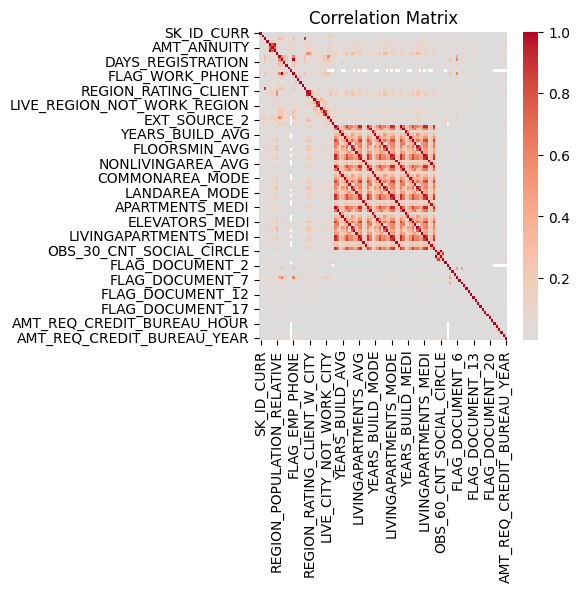


Pairs with |corr| > 0.8:
112 pairs found.
                     feature_1                 feature_2  abs(corr)
913              DAYS_EMPLOYED            FLAG_EMP_PHONE       1.00
3078           YEARS_BUILD_AVG          YEARS_BUILD_MEDI       1.00
5072  OBS_30_CNT_SOCIAL_CIRCLE  OBS_60_CNT_SOCIAL_CIRCLE       1.00
3418             FLOORSMIN_AVG            FLOORSMIN_MEDI       1.00
3352             FLOORSMAX_AVG            FLOORSMAX_MEDI       1.00
...                        ...                       ...        ...
3194             ELEVATORS_AVG      LIVINGAPARTMENTS_AVG       0.81
3542      LIVINGAPARTMENTS_AVG            ELEVATORS_MEDI       0.81
3784           APARTMENTS_MODE            ELEVATORS_MEDI       0.81
4055            ELEVATORS_MODE     LIVINGAPARTMENTS_MODE       0.81
3198             ELEVATORS_AVG           APARTMENTS_MODE       0.81

[112 rows x 3 columns]


In [ ]:
correlation_redundancy(applications, threshold=0.8)

In [105]:
resumen_missing(applications)


Missing values in the DataFrame
                          missing_count  missing_pct
COMMONAREA_MEDI                  214865        69.87
COMMONAREA_MODE                  214865        69.87
COMMONAREA_AVG                   214865        69.87
NONLIVINGAPARTMENTS_MODE         213514        69.43
NONLIVINGAPARTMENTS_MEDI         213514        69.43
NONLIVINGAPARTMENTS_AVG          213514        69.43
FONDKAPREMONT_MODE               210295        68.39
LIVINGAPARTMENTS_AVG             210199        68.35
LIVINGAPARTMENTS_MEDI            210199        68.35
LIVINGAPARTMENTS_MODE            210199        68.35
FLOORSMIN_MEDI                   208642        67.85
FLOORSMIN_MODE                   208642        67.85
FLOORSMIN_AVG                    208642        67.85
YEARS_BUILD_MODE                 204488        66.50
YEARS_BUILD_MEDI                 204488        66.50


In [48]:
correlation_target(applications)

Top 10 correlations with TARGET:



EXT_SOURCE_3                  -0.18
EXT_SOURCE_2                  -0.16
EXT_SOURCE_1                  -0.16
DAYS_BIRTH                     0.08
REGION_RATING_CLIENT_W_CITY    0.06
REGION_RATING_CLIENT           0.06
DAYS_LAST_PHONE_CHANGE         0.06
DAYS_ID_PUBLISH                0.05
REG_CITY_NOT_WORK_CITY         0.05
FLAG_EMP_PHONE                 0.05
Name: TARGET, dtype: float64

# installments_payments

In [106]:
installments_payments = pd.read_csv(r"home-credit-default-risk/installments_payments.csv.gz", compression='gzip')
structural_summary(installments_payments, "installments_payments", key_cols=["SK_ID_PREV","SK_ID_CURR"])

dataset                    installments_payments
rows                                    13605401
columns                                        8
avg_missing (%)                             0.01
n_numeric                                      8
n_categorical                                  0
n_bool                                         0
n_object                                       0
SK_ID_PREV__exists                          True
SK_ID_PREV__unique_rows                    False
SK_ID_PREV__nulls                              0
SK_ID_CURR__exists                          True
SK_ID_CURR__unique_rows                    False
SK_ID_CURR__nulls                              0
dtype: object

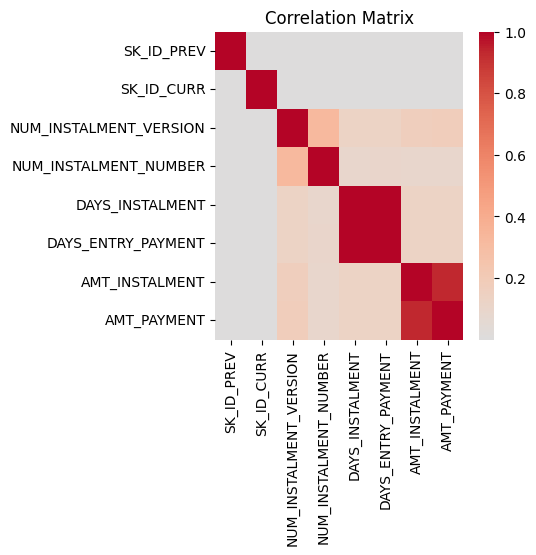


Pairs with |corr| > 0.8:
2 pairs found.
          feature_1           feature_2  abs(corr)
22  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT       1.00
27   AMT_INSTALMENT         AMT_PAYMENT       0.94


In [107]:
correlation_redundancy(installments_payments, threshold=0.8)

In [108]:
resumen_missing(installments_payments)


Missing values in the DataFrame
                    missing_count  missing_pct
DAYS_ENTRY_PAYMENT           2905         0.02
AMT_PAYMENT                  2905         0.02


In [12]:
installments_payments_target = installments_payments.merge(
    applications[['SK_ID_CURR', 'TARGET']],
    on='SK_ID_CURR',
    how='left'
)

correlation_target(installments_payments_target)

Top 10 correlations with TARGET:



DAYS_ENTRY_PAYMENT        0.04
DAYS_INSTALMENT           0.03
NUM_INSTALMENT_NUMBER    -0.02
NUM_INSTALMENT_VERSION   -0.01
AMT_PAYMENT              -0.00
SK_ID_CURR               -0.00
AMT_INSTALMENT           -0.00
SK_ID_PREV               -0.00
Name: TARGET, dtype: float64

NUM_INSTALMENT_VERSION
count             13605401.00
mean                     0.86
std                      1.04
min                      0.00
1%                       0.00
5%                       0.00
25%                      0.00
50%                      1.00
75%                      1.00
95%                      2.00
99%                      4.00
max                    178.00

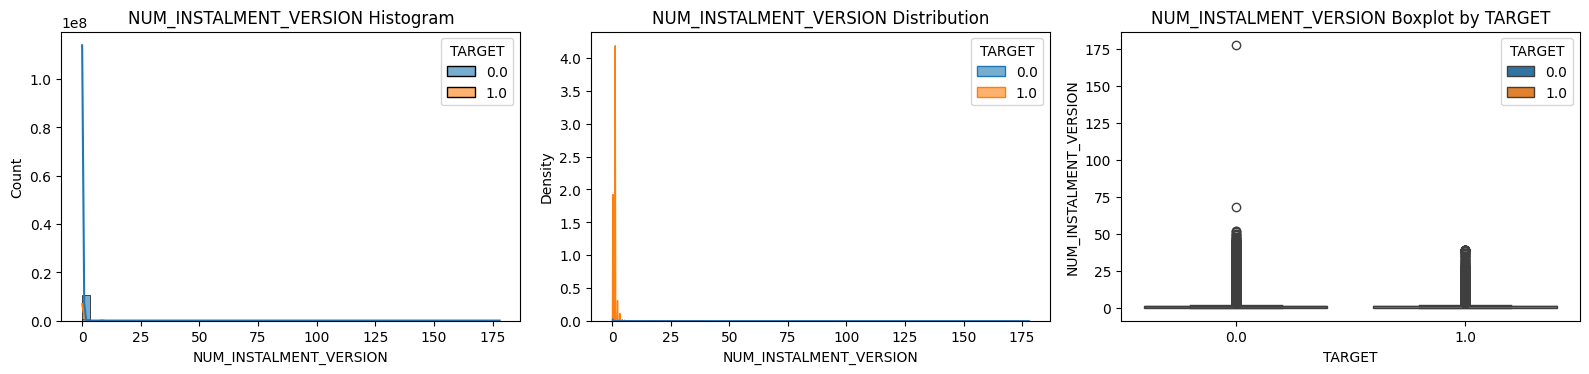

NUM_INSTALMENT_NUMBER
count            13605401.00
mean                   18.87
std                    26.66
min                     1.00
1%                      1.00
5%                      1.00
25%                     4.00
50%                     8.00
75%                    19.00
95%                    82.00
99%                   121.00
max                   277.00

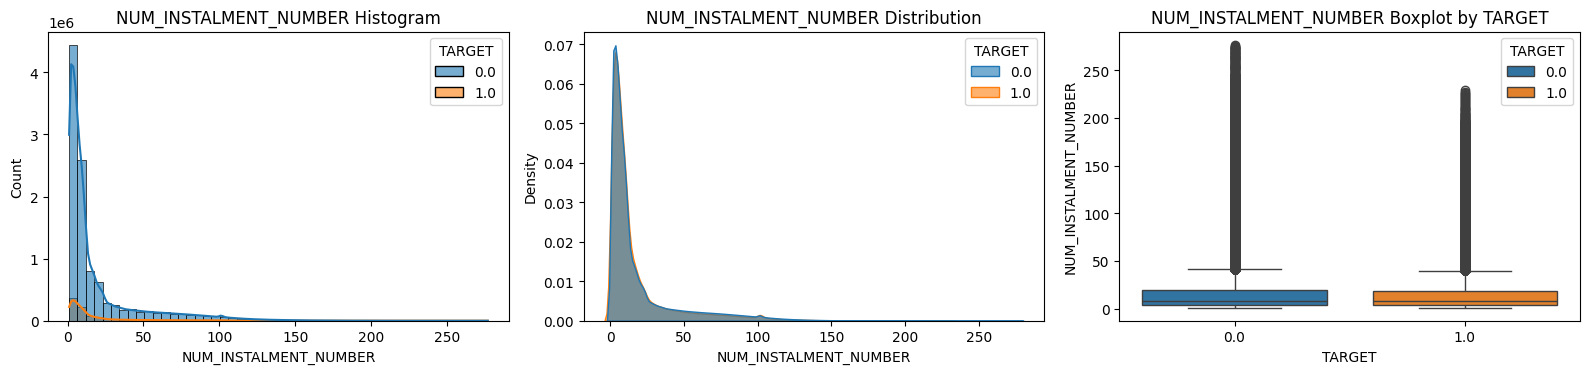

DAYS_INSTALMENT
count      13605401.00
mean          -1042.27
std             800.95
min           -2922.00
1%            -2832.00
5%            -2553.00
25%           -1654.00
50%            -818.00
75%            -361.00
95%             -81.00
99%             -21.00
max              -1.00

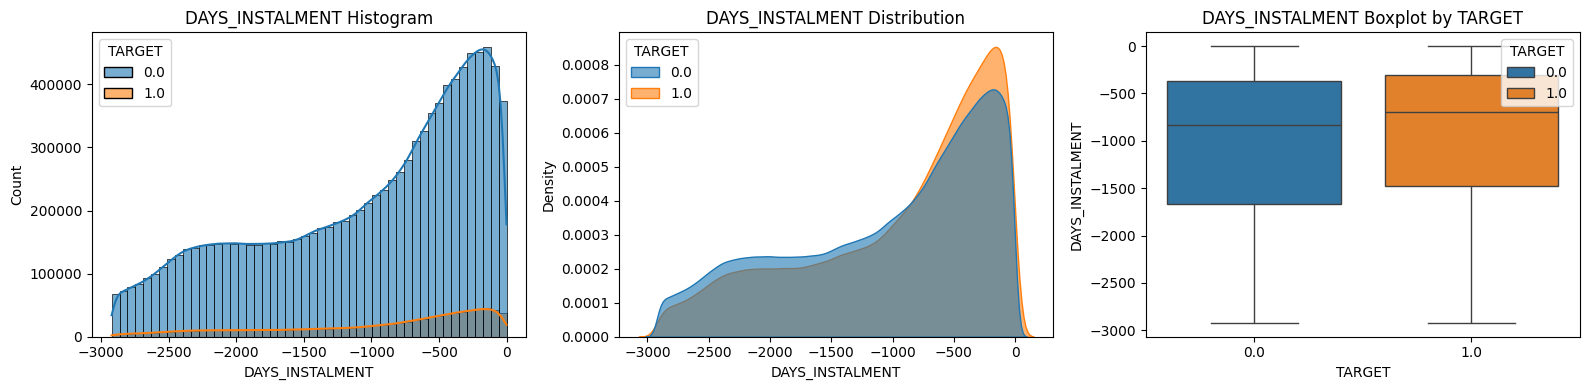

DAYS_ENTRY_PAYMENT
count         13602496.00
mean             -1051.11
std                800.59
min              -4921.00
1%               -2837.00
5%               -2561.00
25%              -1662.00
50%               -827.00
75%               -370.00
95%                -90.00
99%                -28.00
max                 -1.00

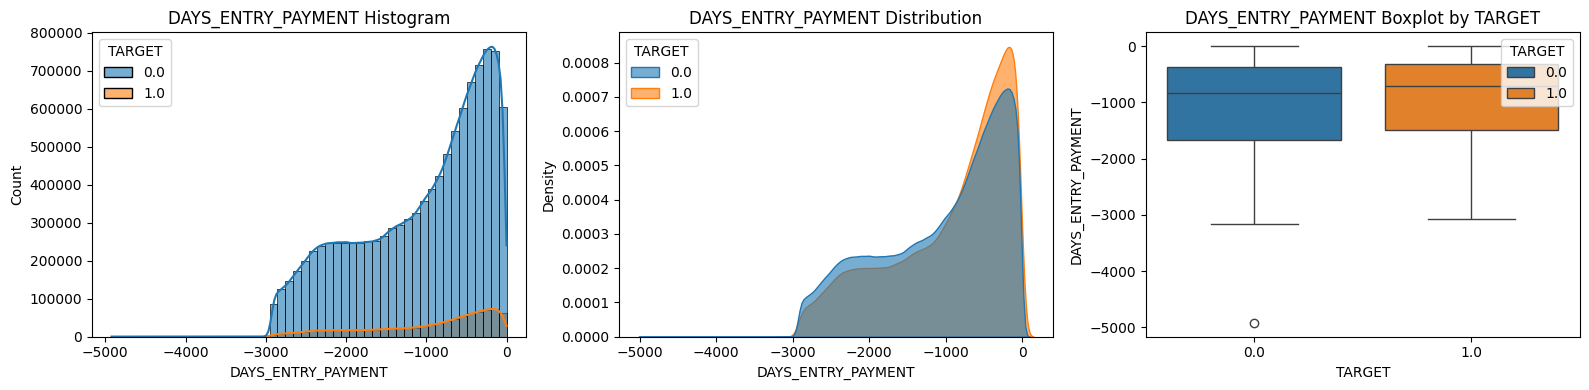

AMT_INSTALMENT
count     13605401.00
mean         17050.91
std          50570.25
min              0.00
1%              13.28
5%             188.15
25%           4226.09
50%           8884.08
75%          16710.21
95%          47041.33
99%         146068.70
max        3771487.85

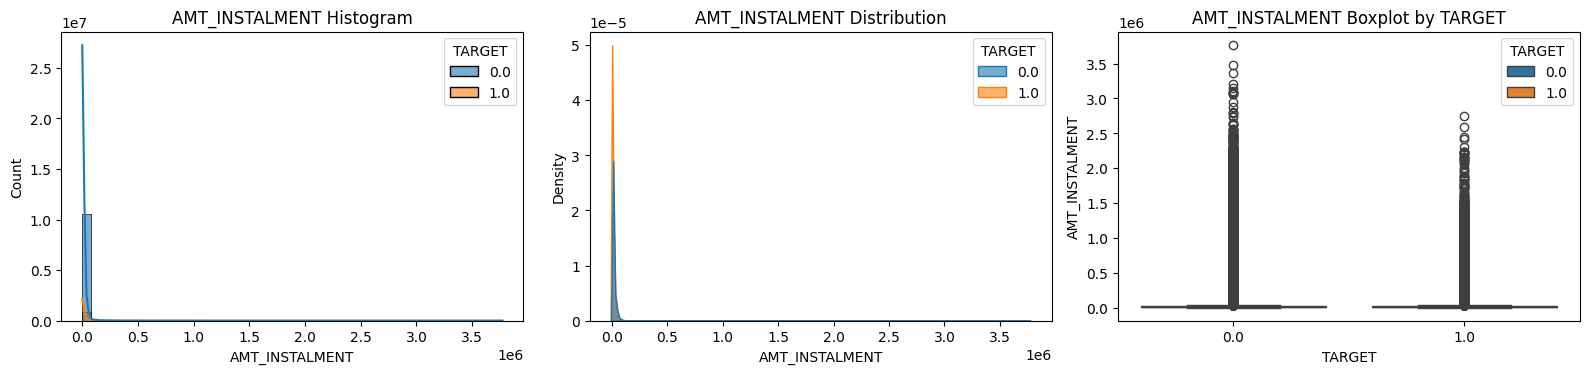

AMT_PAYMENT
count  13602496.00
mean      17238.22
std       54735.78
min           0.00
1%            3.78
5%          111.64
25%        3398.26
50%        8125.52
75%       16108.42
95%       47732.18
99%      178003.96
max     3771487.85

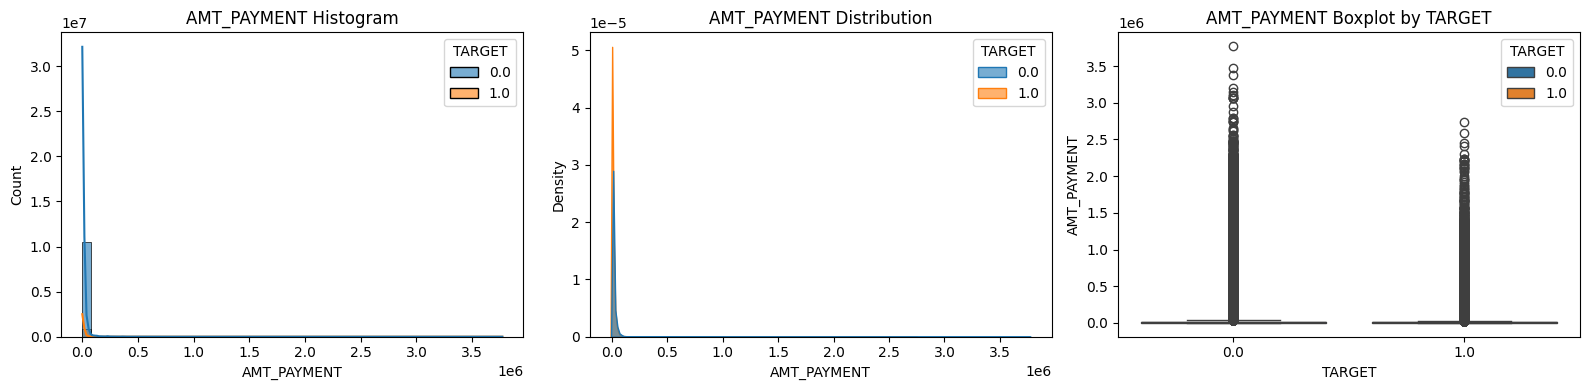

In [25]:
hist_boxplot_numeric_df(installments_payments_target)

In [ ]:
gc.enable()
del installments_payments_target, installments_payments
gc.collect()

87399

# credit_card_balance

In [111]:
credit_card_balance = pd.read_csv(r"home-credit-default-risk/credit_card_balance.csv.gz", compression='gzip')
structural_summary(credit_card_balance, "credit_card_balance", key_cols=["SK_ID_PREV", "SK_ID_CURR"])

dataset                    credit_card_balance
rows                                   3840312
columns                                     23
avg_missing (%)                           6.65
n_numeric                                   22
n_categorical                                1
n_bool                                       0
n_object                                     1
SK_ID_PREV__exists                        True
SK_ID_PREV__unique_rows                  False
SK_ID_PREV__nulls                            0
SK_ID_CURR__exists                        True
SK_ID_CURR__unique_rows                  False
SK_ID_CURR__nulls                            0
dtype: object

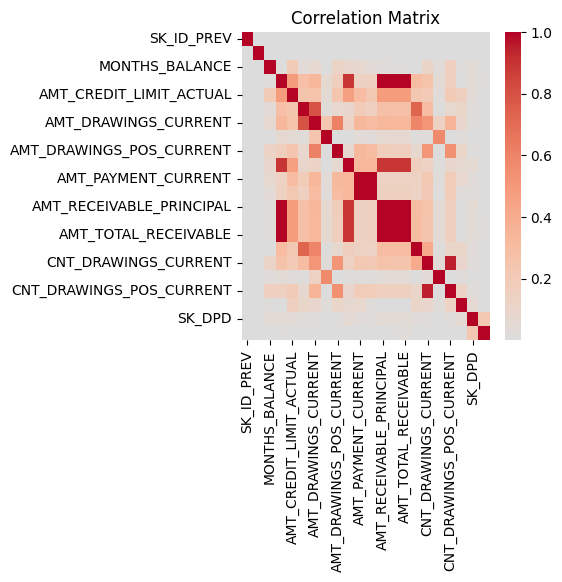


Pairs with |corr| > 0.8:
13 pairs found.
                    feature_1                  feature_2  abs(corr)
195             AMT_RECIVABLE       AMT_TOTAL_RECEIVABLE       1.00
69                AMT_BALANCE              AMT_RECIVABLE       1.00
70                AMT_BALANCE       AMT_TOTAL_RECEIVABLE       1.00
186  AMT_RECEIVABLE_PRINCIPAL              AMT_RECIVABLE       1.00
68                AMT_BALANCE   AMT_RECEIVABLE_PRINCIPAL       1.00
187  AMT_RECEIVABLE_PRINCIPAL       AMT_TOTAL_RECEIVABLE       1.00
165       AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT       0.99
217      CNT_DRAWINGS_CURRENT   CNT_DRAWINGS_POS_CURRENT       0.95
156   AMT_INST_MIN_REGULARITY              AMT_RECIVABLE       0.90
157   AMT_INST_MIN_REGULARITY       AMT_TOTAL_RECEIVABLE       0.90
65                AMT_BALANCE    AMT_INST_MIN_REGULARITY       0.90
155   AMT_INST_MIN_REGULARITY   AMT_RECEIVABLE_PRINCIPAL       0.90
95   AMT_DRAWINGS_ATM_CURRENT       AMT_DRAWINGS_CURRENT       0.80


In [112]:
correlation_redundancy(credit_card_balance, threshold=0.8)

In [113]:
resumen_missing(credit_card_balance)


Missing values in the DataFrame
                            missing_count  missing_pct
AMT_PAYMENT_CURRENT                767988        20.00
AMT_DRAWINGS_ATM_CURRENT           749816        19.52
AMT_DRAWINGS_OTHER_CURRENT         749816        19.52
AMT_DRAWINGS_POS_CURRENT           749816        19.52
CNT_DRAWINGS_ATM_CURRENT           749816        19.52
CNT_DRAWINGS_POS_CURRENT           749816        19.52
CNT_DRAWINGS_OTHER_CURRENT         749816        19.52
AMT_INST_MIN_REGULARITY            305236         7.95
CNT_INSTALMENT_MATURE_CUM          305236         7.95


In [114]:
credit_card_balance_target = credit_card_balance.merge(
    applications[['SK_ID_CURR', 'TARGET']],
    on='SK_ID_CURR',
    how='left'
)

correlation_target(credit_card_balance_target)

Top 10 correlations with TARGET:



AMT_BALANCE                0.05
AMT_TOTAL_RECEIVABLE       0.05
AMT_RECIVABLE              0.05
AMT_RECEIVABLE_PRINCIPAL   0.05
AMT_INST_MIN_REGULARITY    0.04
CNT_DRAWINGS_ATM_CURRENT   0.04
CNT_DRAWINGS_CURRENT       0.04
MONTHS_BALANCE             0.04
CNT_DRAWINGS_POS_CURRENT   0.03
AMT_DRAWINGS_ATM_CURRENT   0.02
Name: TARGET, dtype: float64

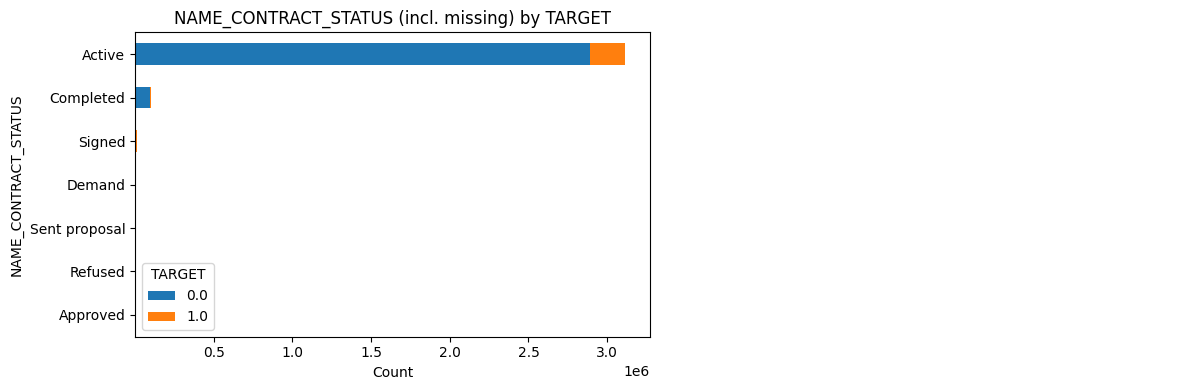

In [53]:
multi_stack_plot(credit_card_balance_target, credit_card_balance_target.select_dtypes(include=["object"]).columns)

MONTHS_BALANCE
count      3840312.00
mean           -34.52
std             26.67
min            -96.00
1%             -93.00
5%             -84.00
25%            -55.00
50%            -28.00
75%            -11.00
95%             -3.00
99%             -1.00
max             -1.00

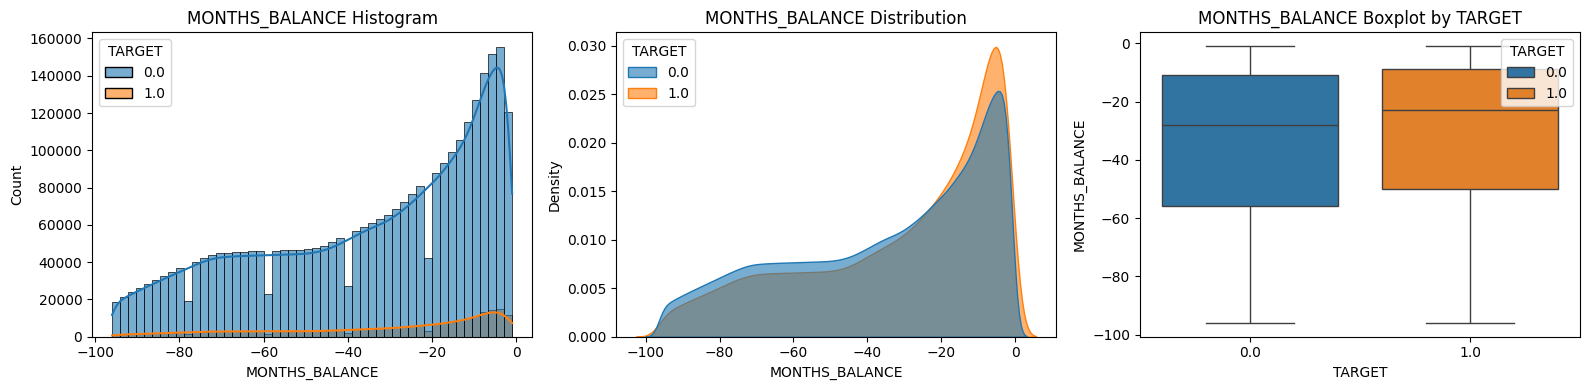

AMT_BALANCE
count   3840312.00
mean      58300.16
std      106307.03
min     -420250.18
1%            0.00
5%            0.00
25%           0.00
50%           0.00
75%       89046.69
95%      257181.38
99%      466295.12
max     1505902.19

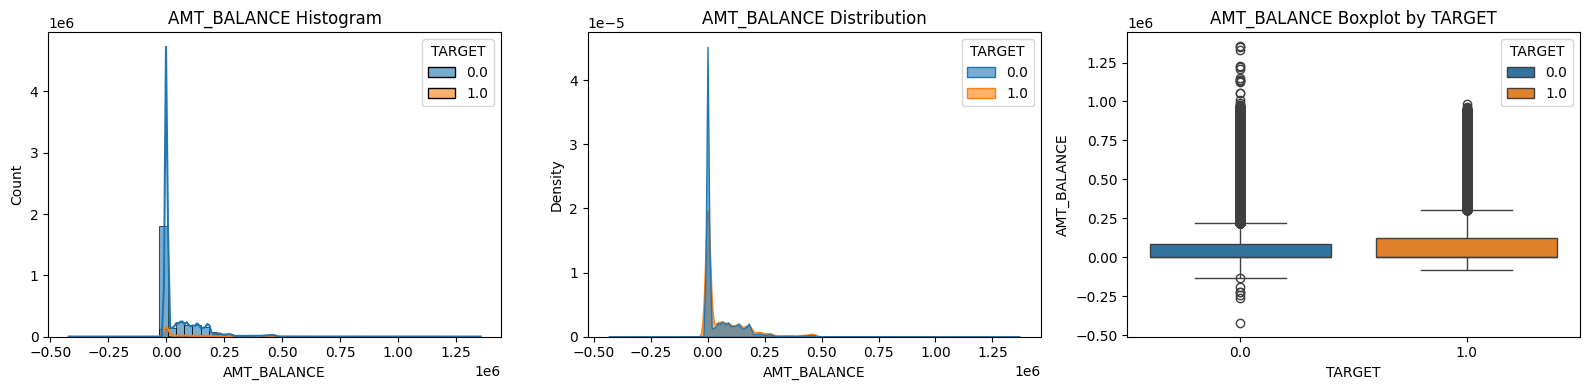

AMT_CREDIT_LIMIT_ACTUAL
count               3840312.00
mean                 153807.96
std                  165145.70
min                       0.00
1%                        0.00
5%                        0.00
25%                   45000.00
50%                  112500.00
75%                  180000.00
95%                  450000.00
99%                  765000.00
max                 1350000.00

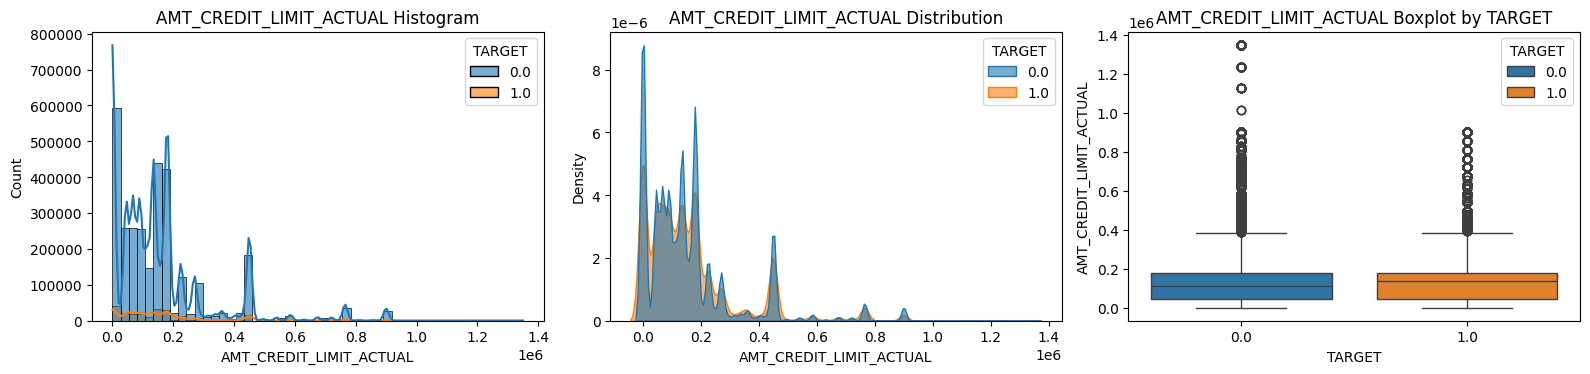

AMT_DRAWINGS_ATM_CURRENT
count                3090496.00
mean                    5961.32
std                    28225.69
min                    -6827.31
1%                         0.00
5%                         0.00
25%                        0.00
50%                        0.00
75%                        0.00
95%                    33750.00
99%                   135000.00
max                  2115000.00

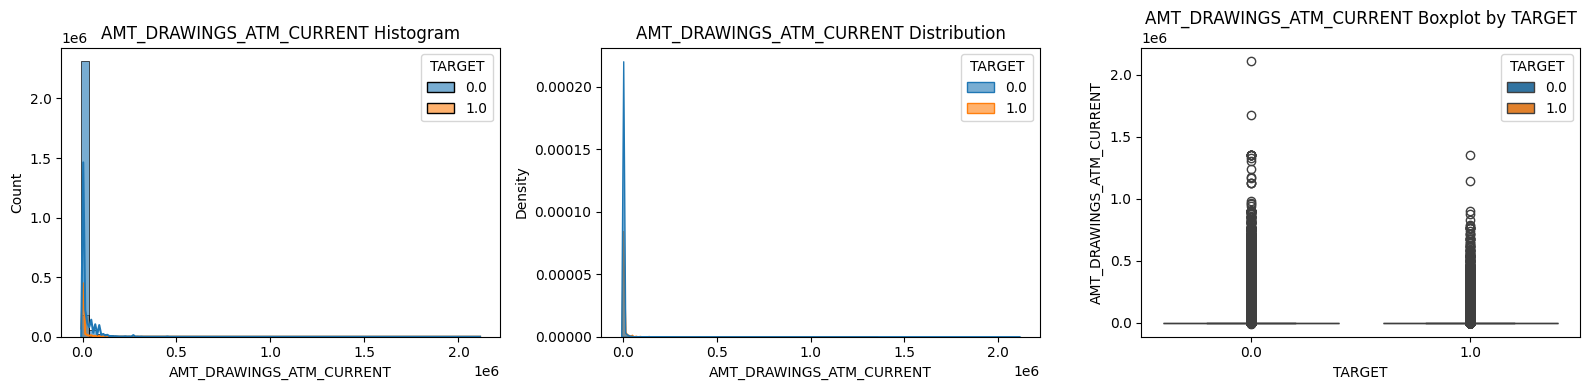

AMT_DRAWINGS_CURRENT
count            3840312.00
mean                7433.39
std                33846.08
min                -6211.62
1%                     0.00
5%                     0.00
25%                    0.00
50%                    0.00
75%                    0.00
95%                45000.00
99%               157500.00
max              2287098.31

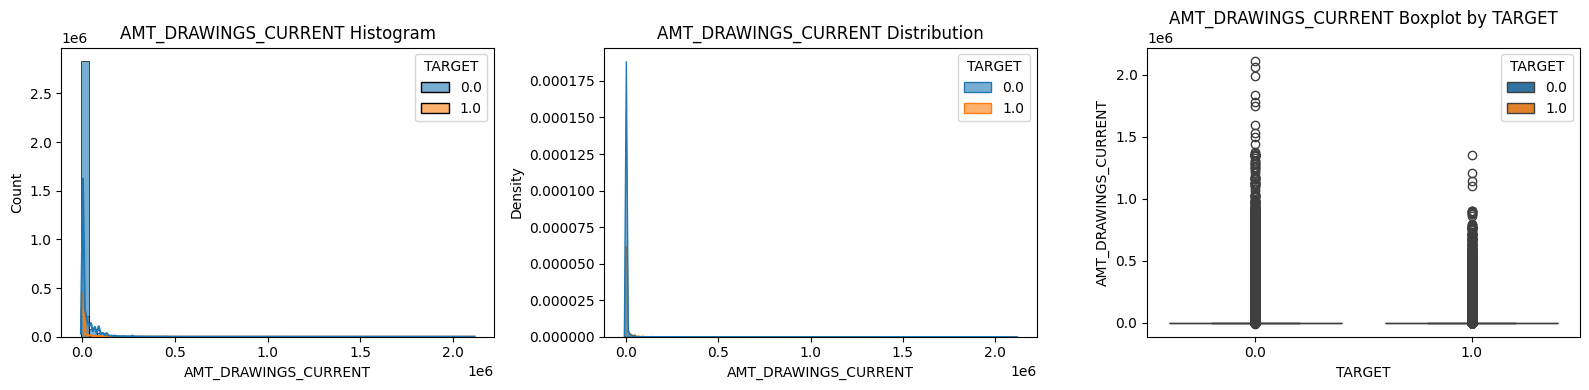

AMT_DRAWINGS_OTHER_CURRENT
count                  3090496.00
mean                       288.17
std                       8201.99
min                          0.00
1%                           0.00
5%                           0.00
25%                          0.00
50%                          0.00
75%                          0.00
95%                          0.00
99%                          0.00
max                    1529847.00

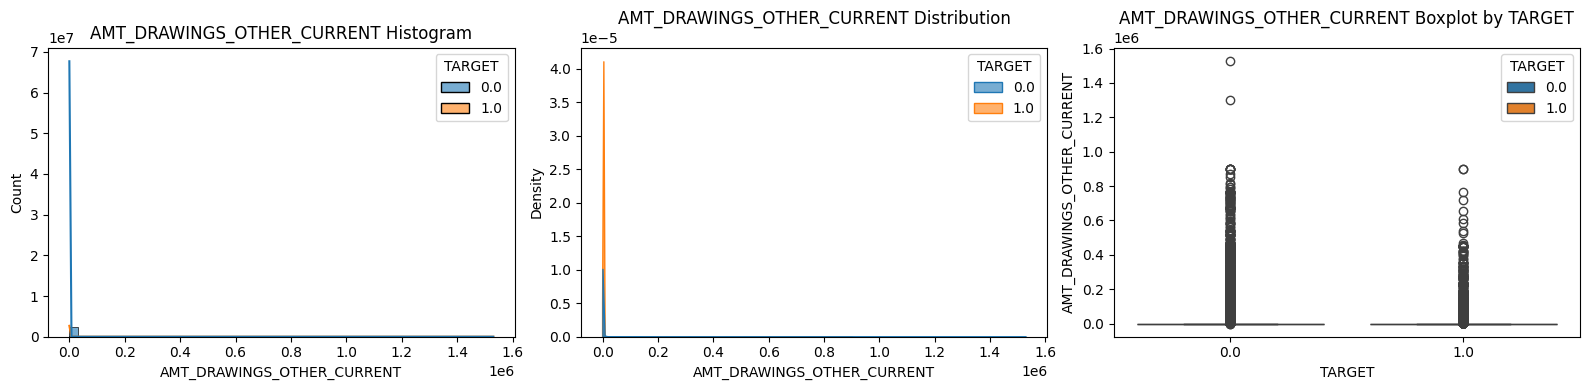

AMT_DRAWINGS_POS_CURRENT
count                3090496.00
mean                    2968.80
std                    20796.89
min                        0.00
1%                         0.00
5%                         0.00
25%                        0.00
50%                        0.00
75%                        0.00
95%                    10116.00
99%                    77080.61
max                  2239274.16

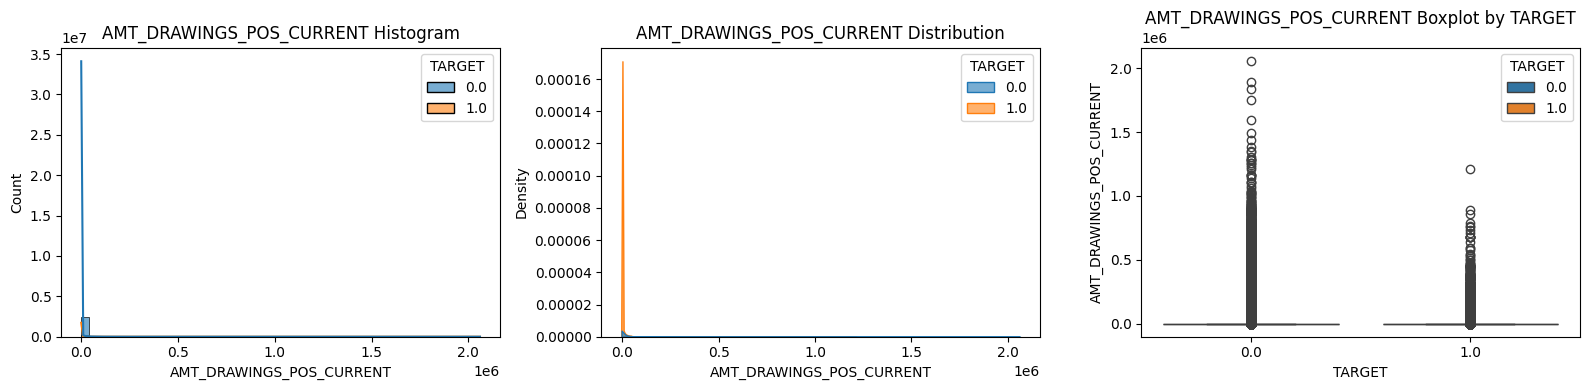

AMT_INST_MIN_REGULARITY
count               3535076.00
mean                   3540.20
std                    5600.15
min                       0.00
1%                        0.00
5%                        0.00
25%                       0.00
50%                       0.00
75%                    6633.91
95%                   13500.00
99%                   23312.80
max                  202882.01

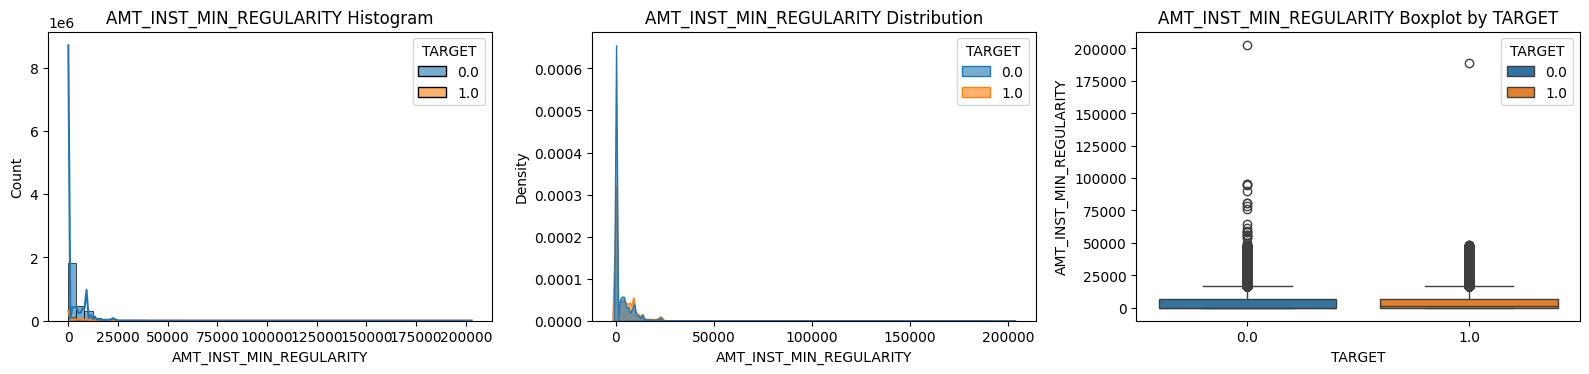

AMT_PAYMENT_CURRENT
count           3072324.00
mean              10280.54
std               36078.08
min                   0.00
1%                    0.00
5%                    0.00
25%                 152.37
50%                2702.70
75%                9000.00
95%               31500.00
99%              150617.43
max             4289207.45

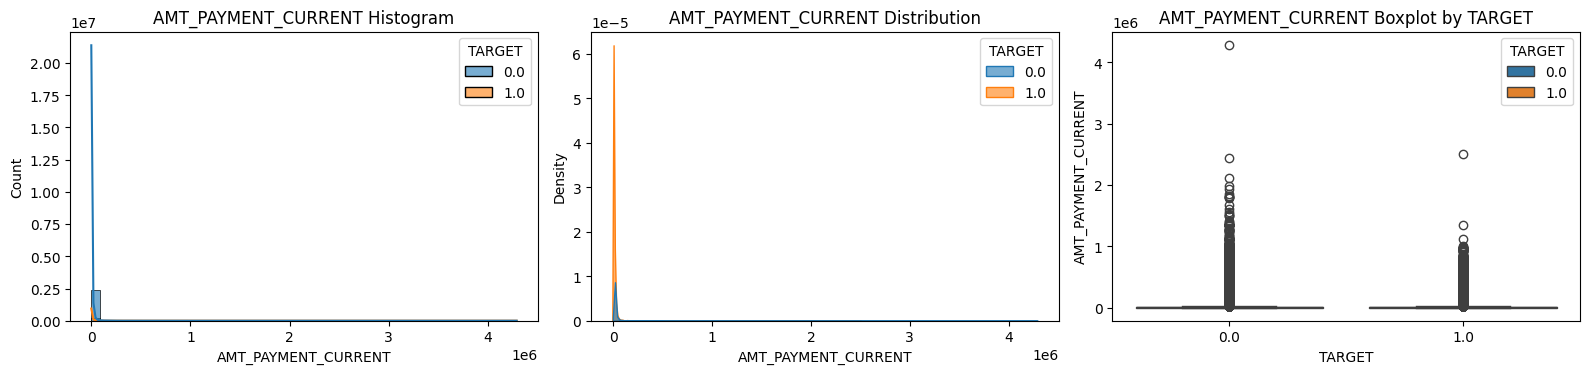

AMT_PAYMENT_TOTAL_CURRENT
count                 3840312.00
mean                     7588.86
std                     32005.99
min                         0.00
1%                          0.00
5%                          0.00
25%                         0.00
50%                         0.00
75%                      6750.00
95%                     23400.00
99%                    128614.93
max                   4278315.69

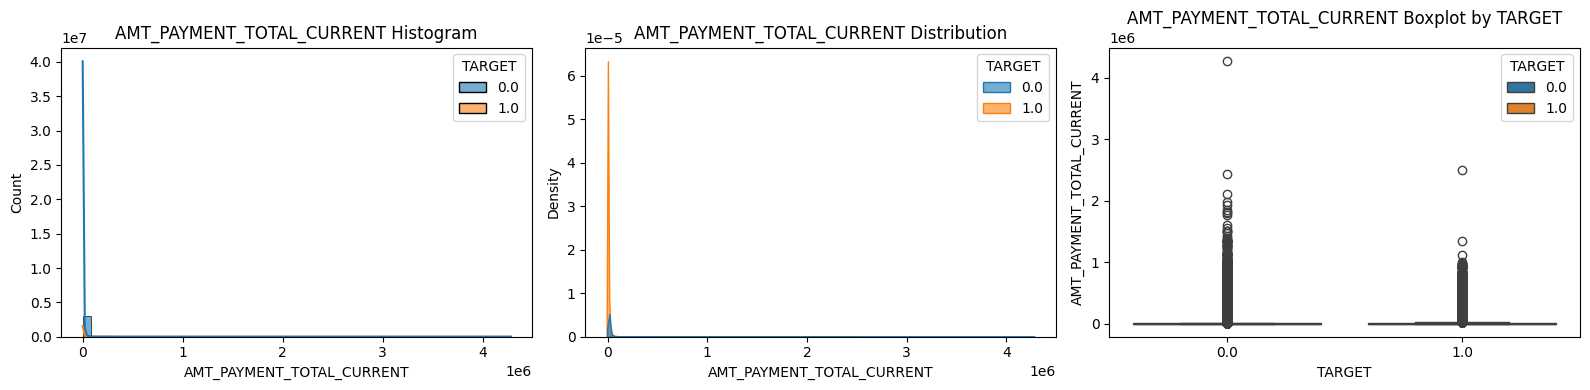

AMT_RECEIVABLE_PRINCIPAL
count                3840312.00
mean                   55965.88
std                   102533.62
min                  -423305.82
1%                         0.00
5%                         0.00
25%                        0.00
50%                        0.00
75%                    85359.24
95%                   247803.41
99%                   448121.83
max                  1472316.79

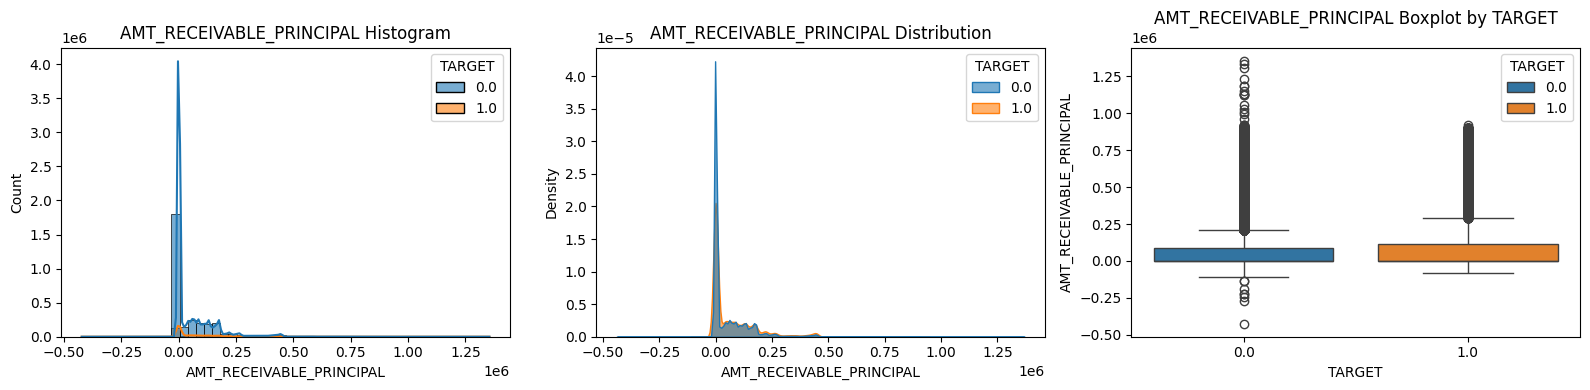

AMT_RECIVABLE
count     3840312.00
mean        58088.81
std        105965.37
min       -420250.18
1%           -487.26
5%              0.00
25%             0.00
50%             0.00
75%         88899.49
95%        256445.41
99%        464023.86
max       1493338.19

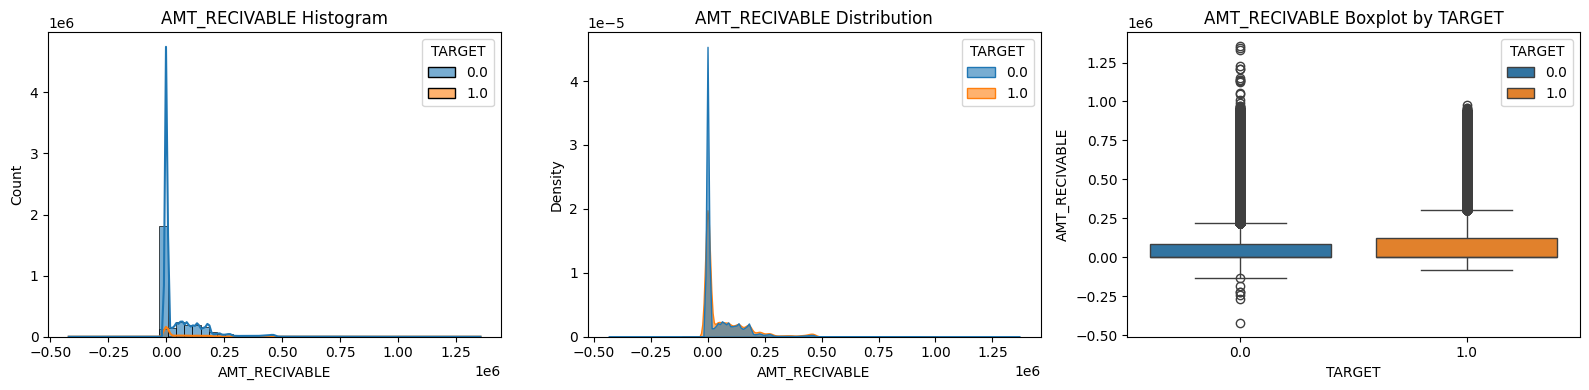

AMT_TOTAL_RECEIVABLE
count            3840312.00
mean               58098.29
std               105971.80
min              -420250.18
1%                  -486.63
5%                     0.00
25%                    0.00
50%                    0.00
75%                88914.51
95%               256468.50
99%               464025.51
max              1493338.19

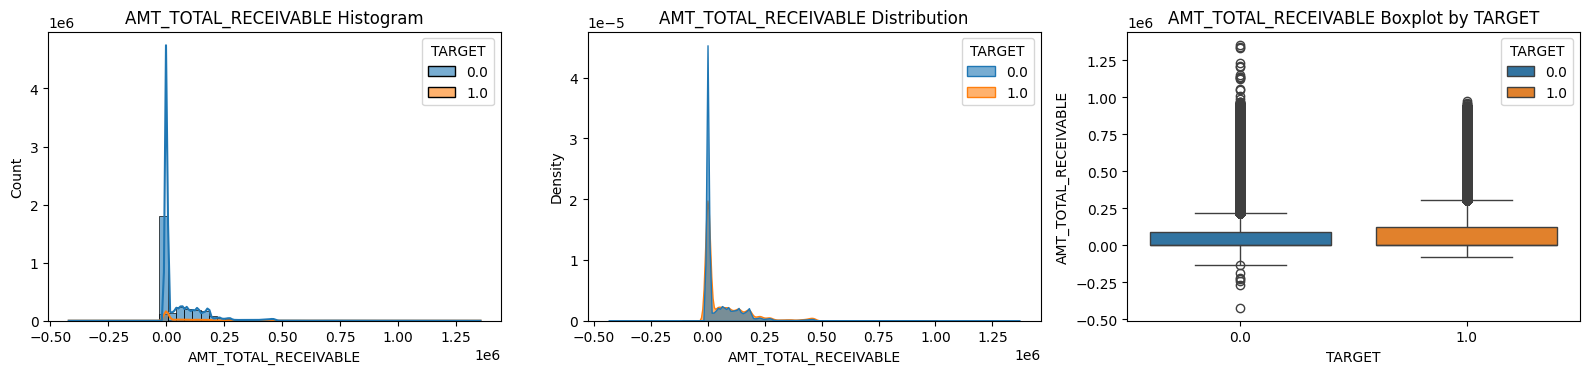

CNT_DRAWINGS_ATM_CURRENT
count                3090496.00
mean                       0.31
std                        1.10
min                        0.00
1%                         0.00
5%                         0.00
25%                        0.00
50%                        0.00
75%                        0.00
95%                        2.00
99%                        5.00
max                       51.00

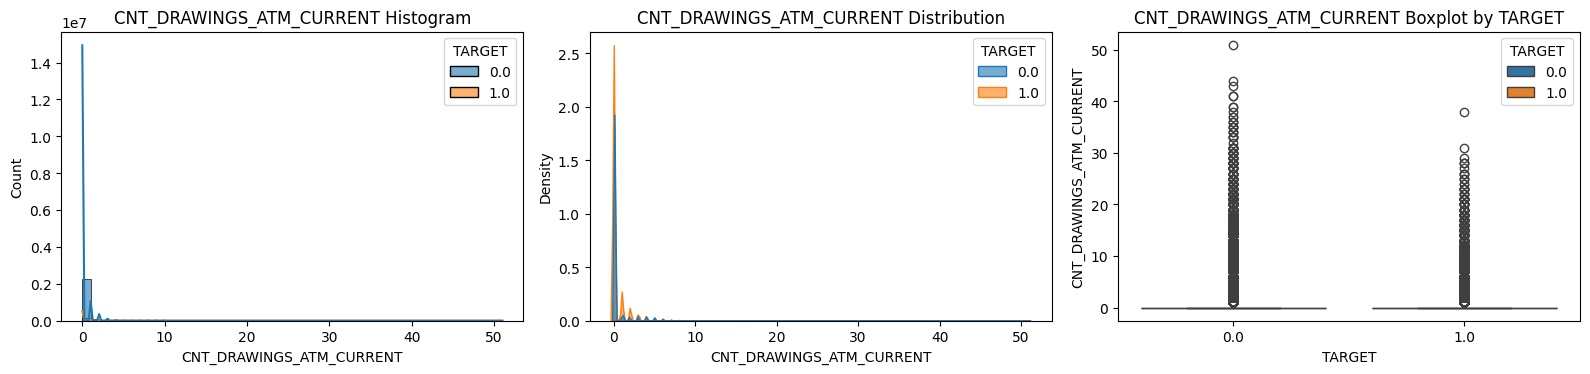

CNT_DRAWINGS_CURRENT
count            3840312.00
mean                   0.70
std                    3.19
min                    0.00
1%                     0.00
5%                     0.00
25%                    0.00
50%                    0.00
75%                    0.00
95%                    4.00
99%                   14.00
max                  165.00

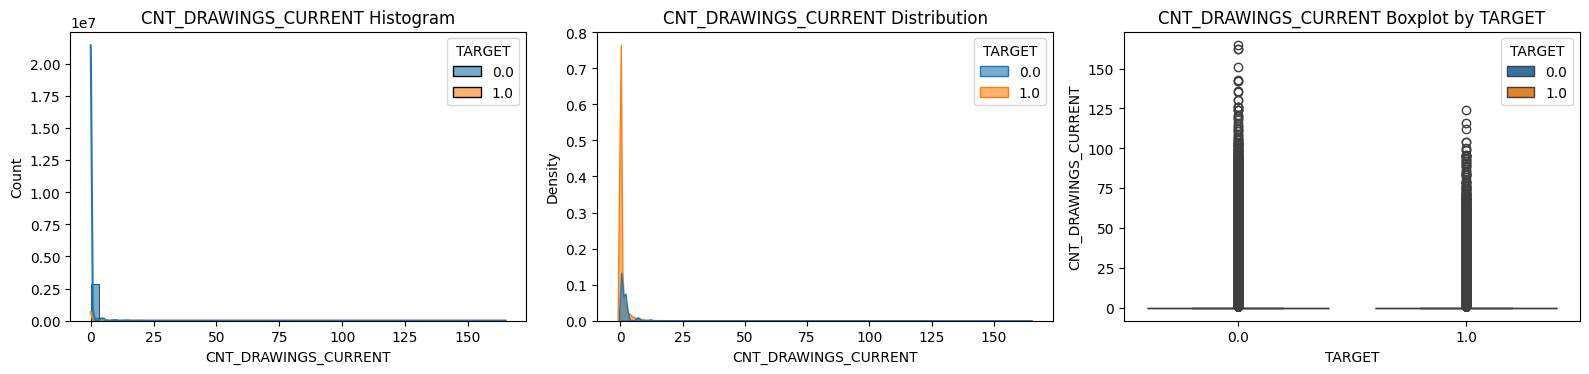

CNT_DRAWINGS_OTHER_CURRENT
count                  3090496.00
mean                         0.00
std                          0.08
min                          0.00
1%                           0.00
5%                           0.00
25%                          0.00
50%                          0.00
75%                          0.00
95%                          0.00
99%                          0.00
max                         12.00

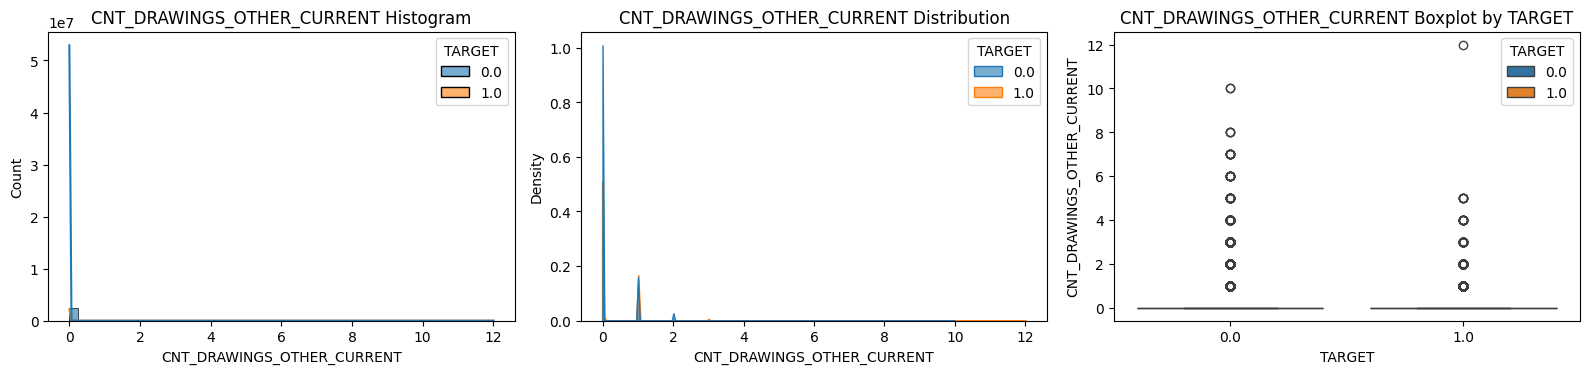

CNT_DRAWINGS_POS_CURRENT
count                3090496.00
mean                       0.56
std                        3.24
min                        0.00
1%                         0.00
5%                         0.00
25%                        0.00
50%                        0.00
75%                        0.00
95%                        2.00
99%                       14.00
max                      165.00

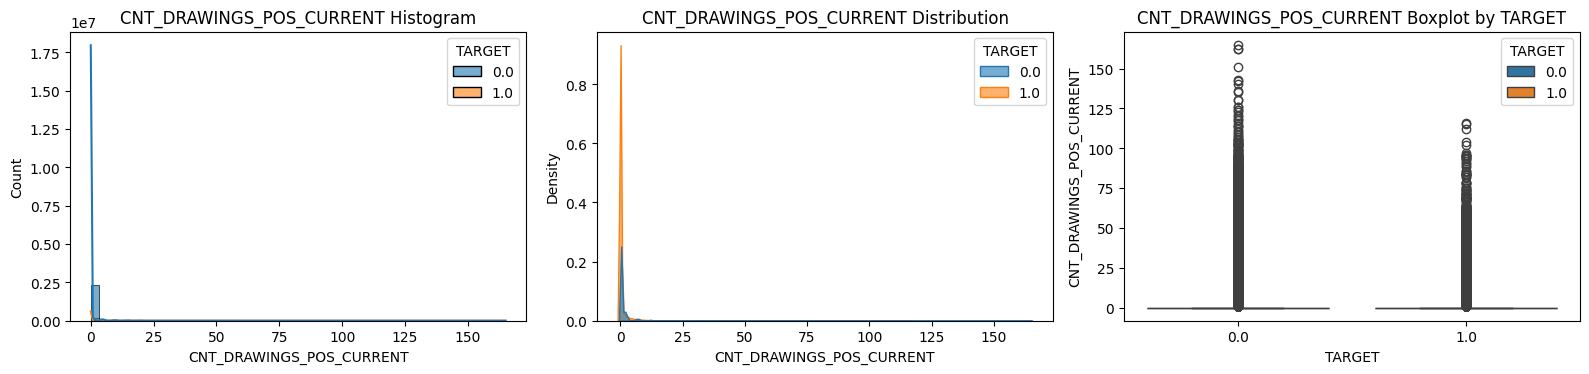

CNT_INSTALMENT_MATURE_CUM
count                 3535076.00
mean                       20.83
std                        20.05
min                         0.00
1%                          0.00
5%                          0.00
25%                         4.00
50%                        15.00
75%                        32.00
95%                        61.00
99%                        80.00
max                       120.00

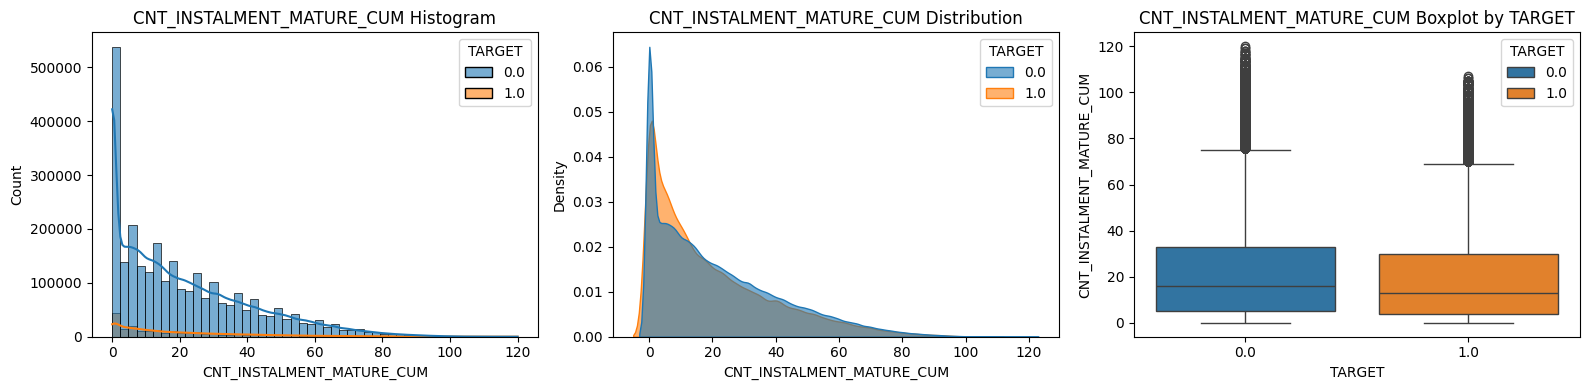

In [54]:
hist_boxplot_numeric_df(credit_card_balance_target)

In [115]:
gc.enable()
del credit_card_balance_target, credit_card_balance
gc.collect()

5878

AMT_BALANCE: There are outliers in both the positive and negative portions; in the negative portion, they only appear in the non-default category. We could discard the negative outliers and also categorize them. This represents the balance for the previous month's credit, categorized as follows: 0 to 25,000, 25,001 to 50,000, 50,001 to 100,000, 100,001 to 125,000, 125,001 to 150,000, 150,001 to 175,000, 175,001 to 200,000, and 200,001 and above. Furthermore, this category has several correlations with others. We can discard the following: AMT_RECIVABLE, AMT_TOTAL_RECEIVABLE, AMT_RECEIVABLE_PRINCIPAL, AMT_INST_MIN_REGULARITY

AMT_CREDIT_LIMIT_ACTUAL: This one already shows a "better" distribution; we could apply a logarithmic (or scaling) method to obtain a better distribution.

AMT_DRAWINGS_ATM_CURRENT: High correlation with AMT_DRAWINGS_CURRENT and 20% missing values; we can discard it for the evaluation.

AMT_DRAWINGS_CURRENT: The amount of money withdrawn during the previous month's credit; we can discard it for the evaluation.

AMT_DRAWINGS_OTHER_CURRENT: We can also discard it.

AMT_DRAWINGS_POS_CURRENT: We can also discard it.

AMT_INST_MIN_REGULARITY: There are outliers at the extreme values; we could Remove, remove as it has a correlation with AMT_BALANCE

AMT_PAYMENT_CURRENT: high correlation with AMT_PAYMENT_TOTAL_CURRENT, discard for evaluation

AMT_PAYMENT_TOTAL_CURRENT: remove outliers from the maximums

AMT_RECEIVABLE_PRINCIPAL: high correlation with AMT_BALANCE, discard for evaluation

AMT_RECIVABLE: high correlation with AMT_BALANCE, discard for evaluation

AMT_TOTAL_RECEIVABLE: high correlation with AMT_BALANCE, discard for evaluation

CNT_DRAWINGS_ATM_CURRENT: Many values ​​of 0, we could categorize it, for now discard it as well as AMT_DRAWINGS_ATM_CURRENT

CNT_DRAWINGS_CURRENT: Discard

CNT_DRAWINGS_OTHER_CURRENT: Discard

CNT_DRAWINGS_POS_CURRENT: Discard

# bureau

In [116]:
bureau = pd.read_csv(r"home-credit-default-risk/bureau.csv.gz", compression='gzip')
structural_summary(bureau, "bureau", key_cols=["SK_ID_CURR", "SK_ID_BUREAU"])

dataset                       bureau
rows                         1716428
columns                           17
avg_missing (%)                13.50
n_numeric                         14
n_categorical                      3
n_bool                             0
n_object                           3
SK_ID_CURR__exists              True
SK_ID_CURR__unique_rows        False
SK_ID_CURR__nulls                  0
SK_ID_BUREAU__exists            True
SK_ID_BUREAU__unique_rows       True
SK_ID_BUREAU__nulls                0
dtype: object

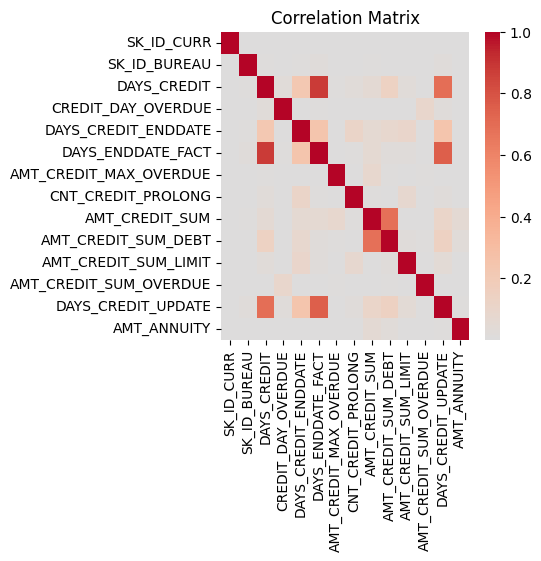


Pairs with |corr| > 0.8:
1 pairs found.
      feature_1          feature_2  abs(corr)
27  DAYS_CREDIT  DAYS_ENDDATE_FACT       0.88


In [117]:
correlation_redundancy(bureau, threshold=0.8)

In [118]:
resumen_missing(bureau)


Missing values in the DataFrame
                        missing_count  missing_pct
AMT_ANNUITY                   1226791        71.47
AMT_CREDIT_MAX_OVERDUE        1124488        65.51
DAYS_ENDDATE_FACT              633653        36.92
AMT_CREDIT_SUM_LIMIT           591780        34.48
AMT_CREDIT_SUM_DEBT            257669        15.01
DAYS_CREDIT_ENDDATE            105553         6.15
AMT_CREDIT_SUM                     13         0.00


In [119]:
bureau_target = bureau.merge(
    applications[['SK_ID_CURR', 'TARGET']],
    on='SK_ID_CURR',
    how='left'
)

correlation_target(bureau_target)

Top 10 correlations with TARGET:



DAYS_CREDIT               0.06
DAYS_CREDIT_UPDATE        0.04
DAYS_ENDDATE_FACT         0.04
DAYS_CREDIT_ENDDATE       0.03
AMT_CREDIT_SUM           -0.01
SK_ID_BUREAU             -0.01
AMT_CREDIT_SUM_OVERDUE    0.01
AMT_CREDIT_SUM_LIMIT     -0.01
SK_ID_CURR               -0.00
CREDIT_DAY_OVERDUE        0.00
Name: TARGET, dtype: float64

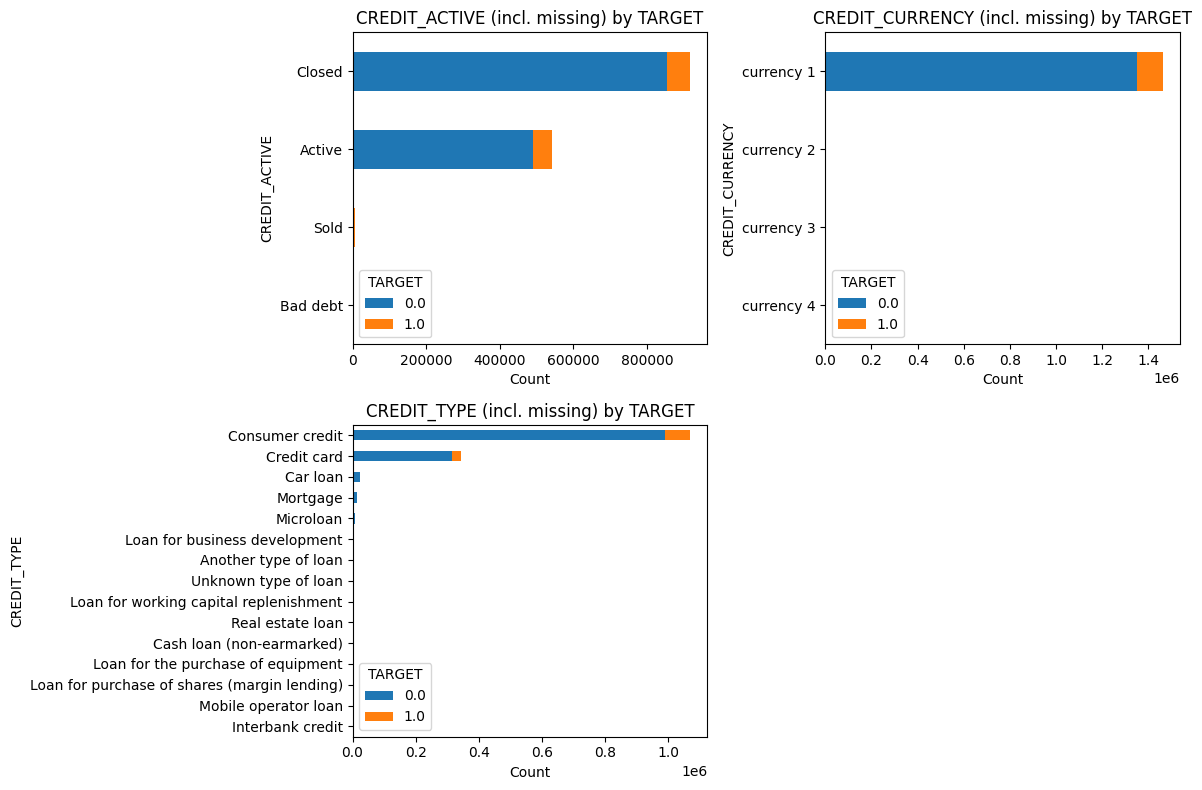

In [60]:
multi_stack_plot(bureau_target, bureau_target.select_dtypes(include=["object"]).columns)

DAYS_CREDIT
count   1716428.00
mean      -1142.11
std         795.16
min       -2922.00
1%        -2867.00
5%        -2665.00
25%       -1666.00
50%        -987.00
75%        -474.00
95%        -125.00
99%         -38.00
max           0.00

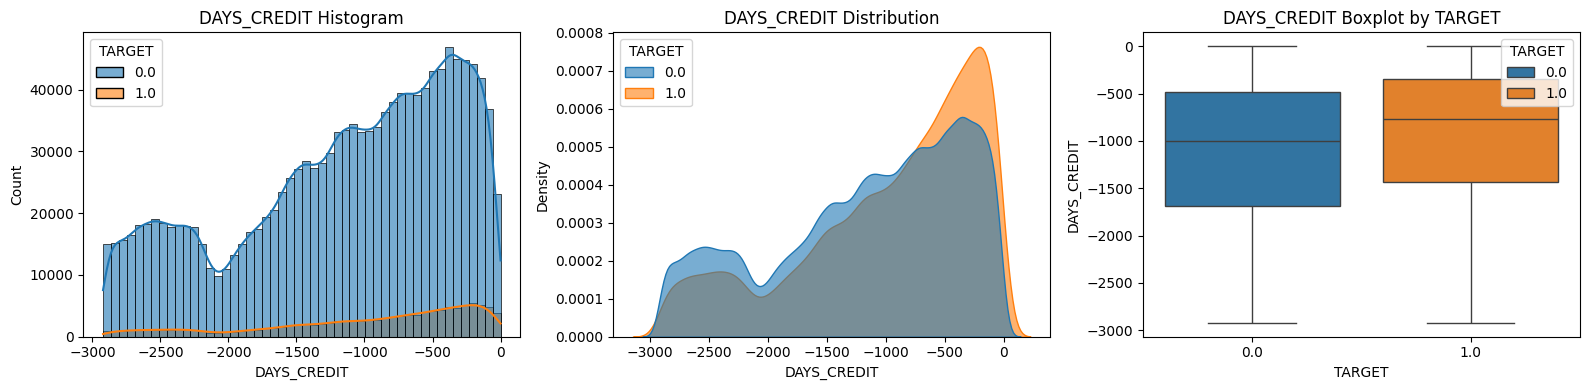

CREDIT_DAY_OVERDUE
count          1716428.00
mean                 0.82
std                 36.54
min                  0.00
1%                   0.00
5%                   0.00
25%                  0.00
50%                  0.00
75%                  0.00
95%                  0.00
99%                  0.00
max               2792.00

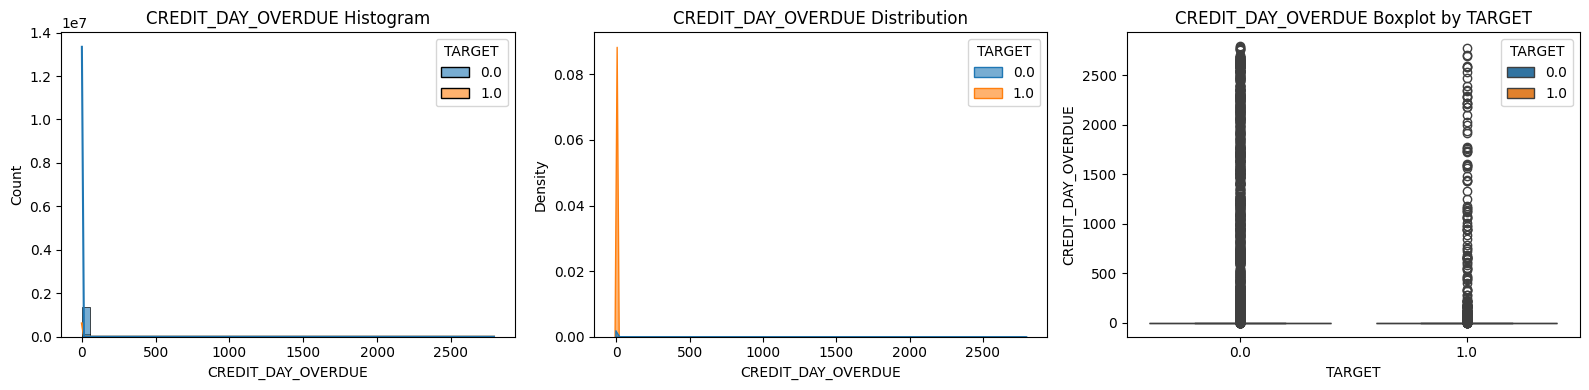

DAYS_CREDIT_ENDDATE
count           1610875.00
mean                510.52
std                4994.22
min              -42060.00
1%                -2571.00
5%                -2262.00
25%               -1138.00
50%                -330.00
75%                 474.00
95%                2623.00
99%               31029.00
max               31199.00

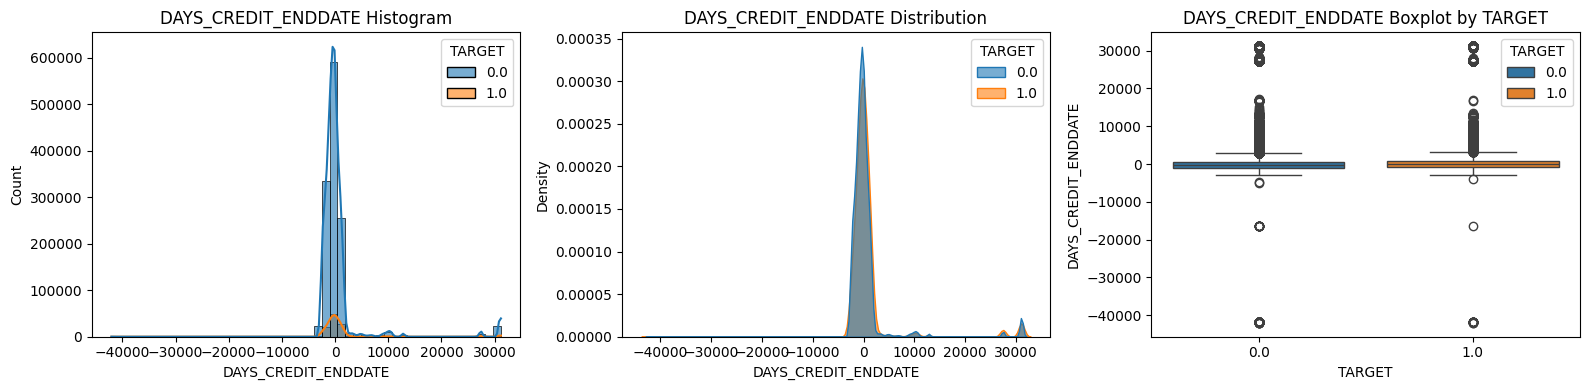

DAYS_ENDDATE_FACT
count         1082775.00
mean            -1017.44
std               714.01
min            -42023.00
1%              -2639.00
5%              -2393.00
25%             -1489.00
50%              -897.00
75%              -425.00
95%               -94.00
99%               -24.00
max                 0.00

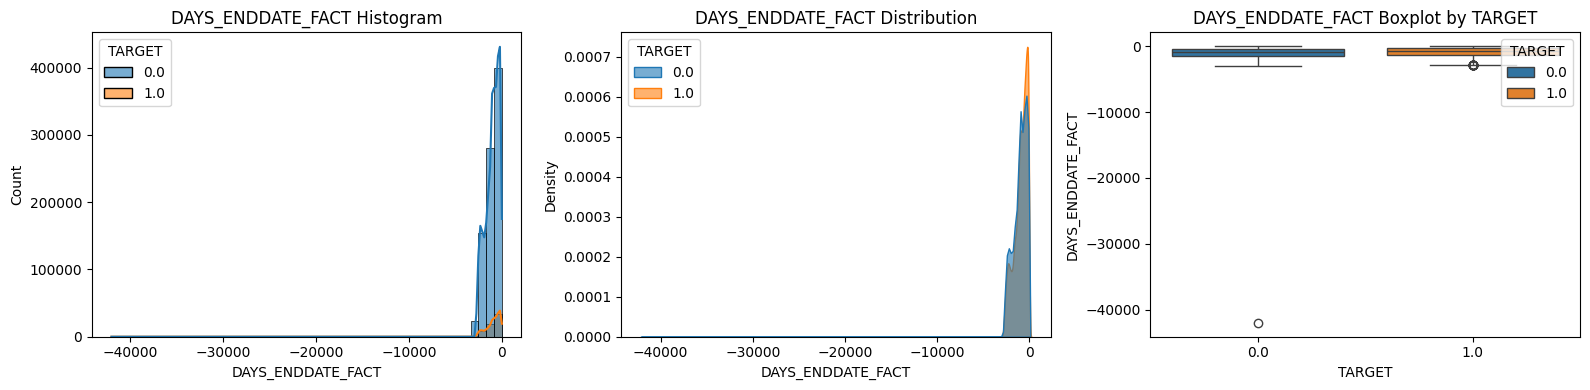

AMT_CREDIT_MAX_OVERDUE
count               591940.00
mean                  3825.42
std                 206031.61
min                      0.00
1%                       0.00
5%                       0.00
25%                      0.00
50%                      0.00
75%                      0.00
95%                  14220.45
99%                  41988.75
max              115987185.00

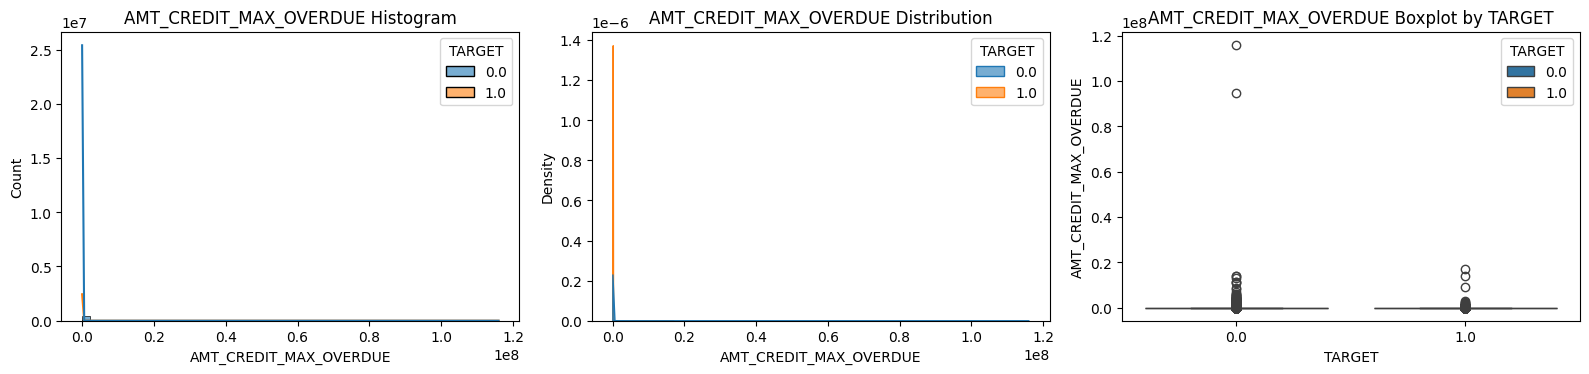

CNT_CREDIT_PROLONG
count          1716428.00
mean                 0.01
std                  0.10
min                  0.00
1%                   0.00
5%                   0.00
25%                  0.00
50%                  0.00
75%                  0.00
95%                  0.00
99%                  0.00
max                  9.00

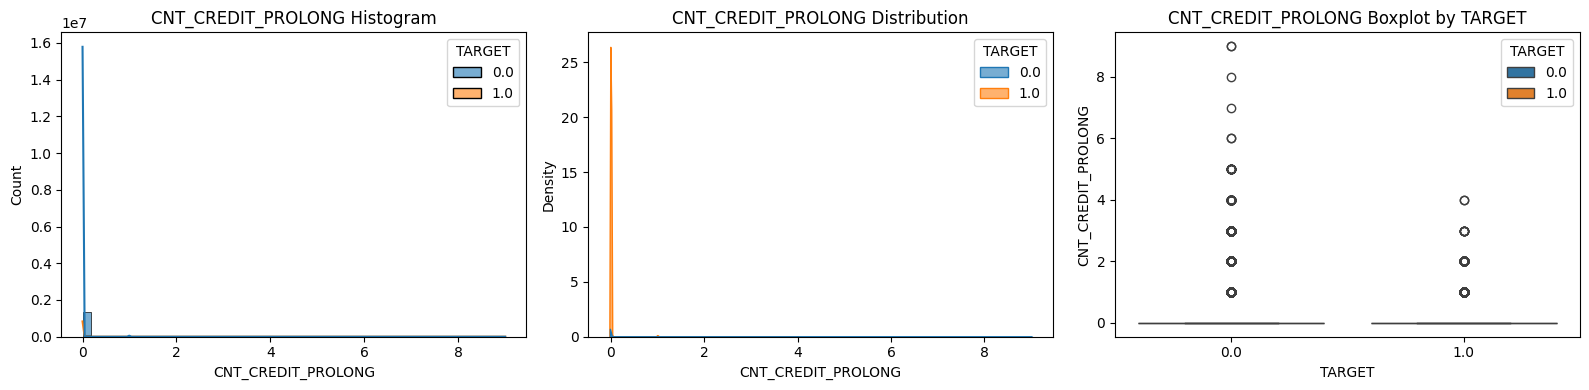

AMT_CREDIT_SUM
count      1716415.00
mean        354994.59
std        1149811.34
min              0.00
1%               0.00
5%           11250.00
25%          51300.00
50%         125518.50
75%         315000.00
95%        1350000.00
99%        3700916.10
max      585000000.00

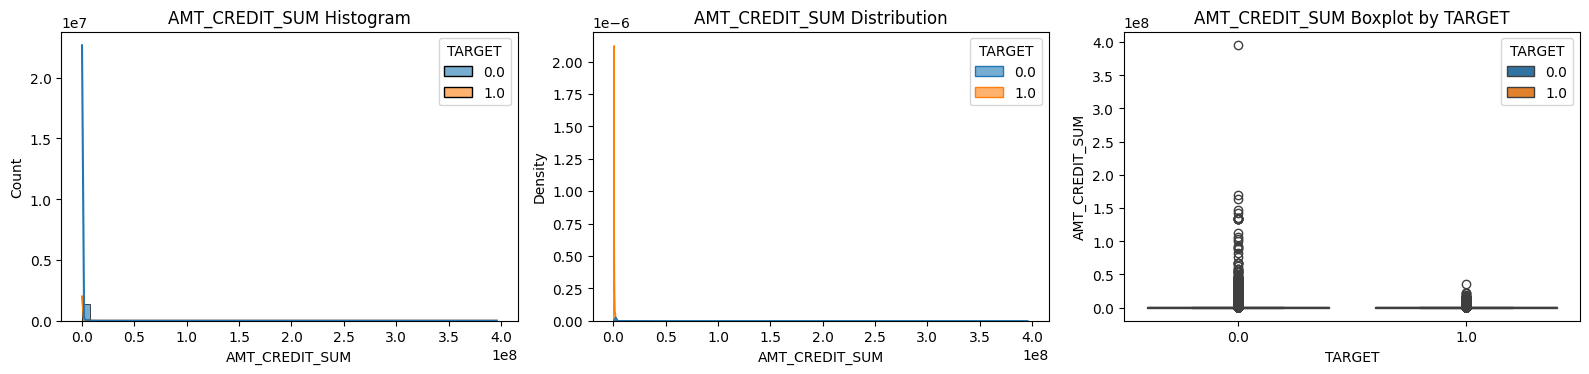

AMT_CREDIT_SUM_DEBT
count           1458759.00
mean             137085.12
std              677401.13
min            -4705600.32
1%                    0.00
5%                    0.00
25%                   0.00
50%                   0.00
75%               40153.50
95%              628902.45
99%             2259728.46
max           170100000.00

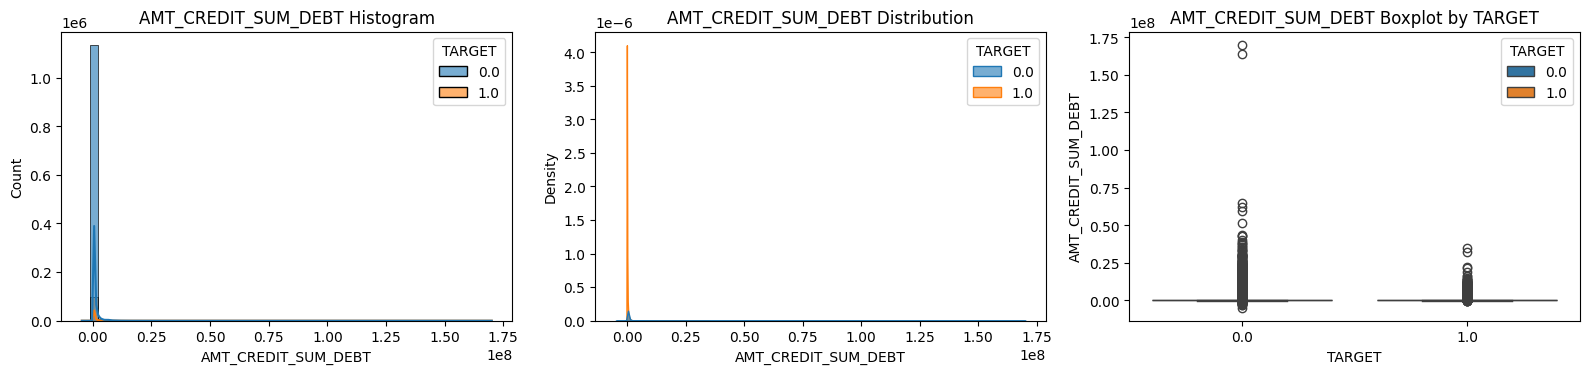

AMT_CREDIT_SUM_LIMIT
count            1124648.00
mean                6229.51
std                45032.03
min              -586406.11
1%                     0.00
5%                     0.00
25%                    0.00
50%                    0.00
75%                    0.00
95%                 5736.07
99%               199620.56
max              4705600.32

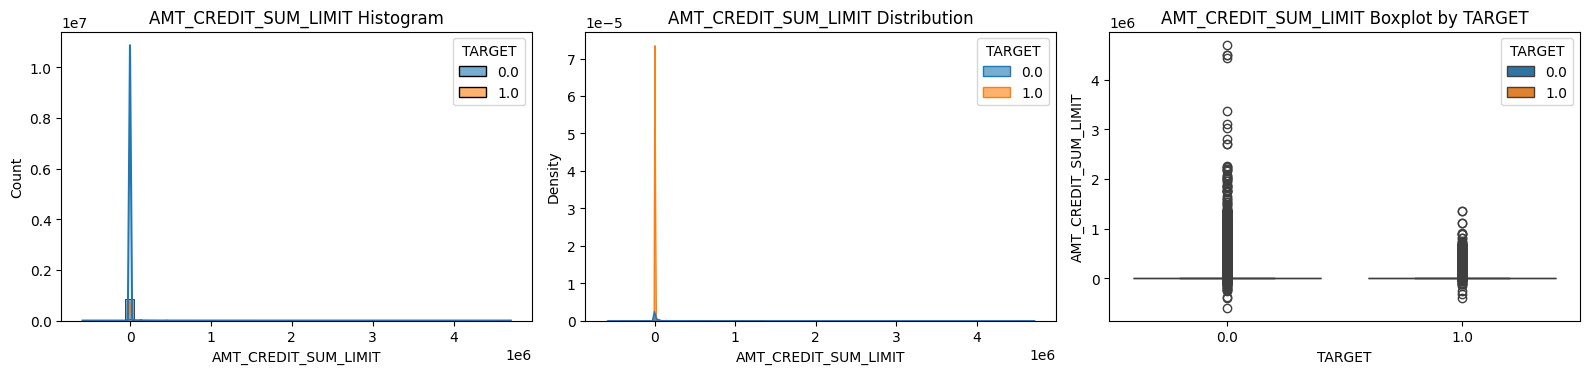

AMT_CREDIT_SUM_OVERDUE
count              1716428.00
mean                    37.91
std                   5937.65
min                      0.00
1%                       0.00
5%                       0.00
25%                      0.00
50%                      0.00
75%                      0.00
95%                      0.00
99%                      0.00
max                3756681.00

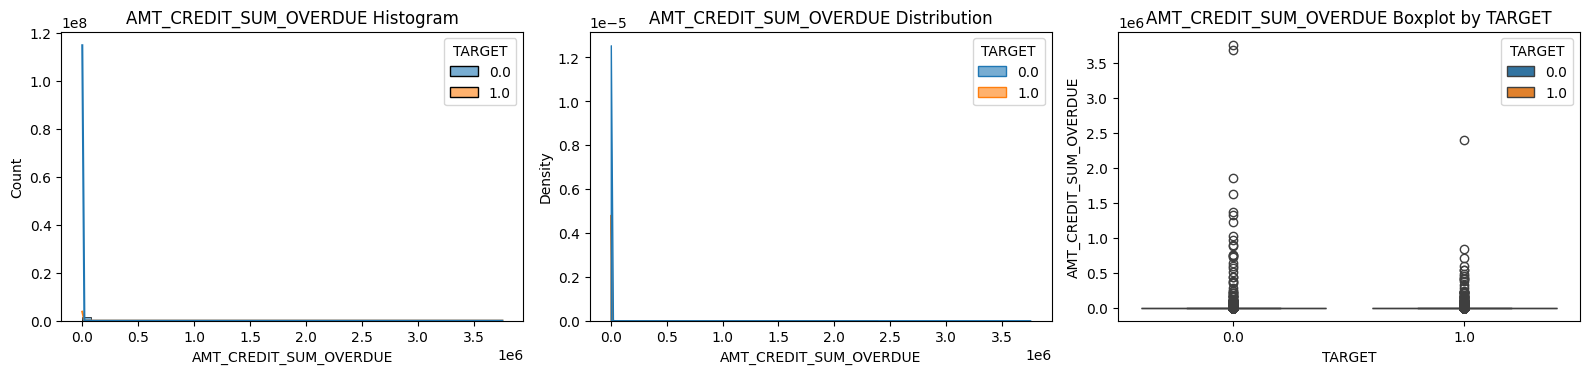

DAYS_CREDIT_UPDATE
count          1716428.00
mean              -593.75
std                720.75
min             -41947.00
1%               -2531.00
5%               -2079.00
25%               -908.00
50%               -395.00
75%                -33.00
95%                 -8.00
99%                 -3.00
max                372.00

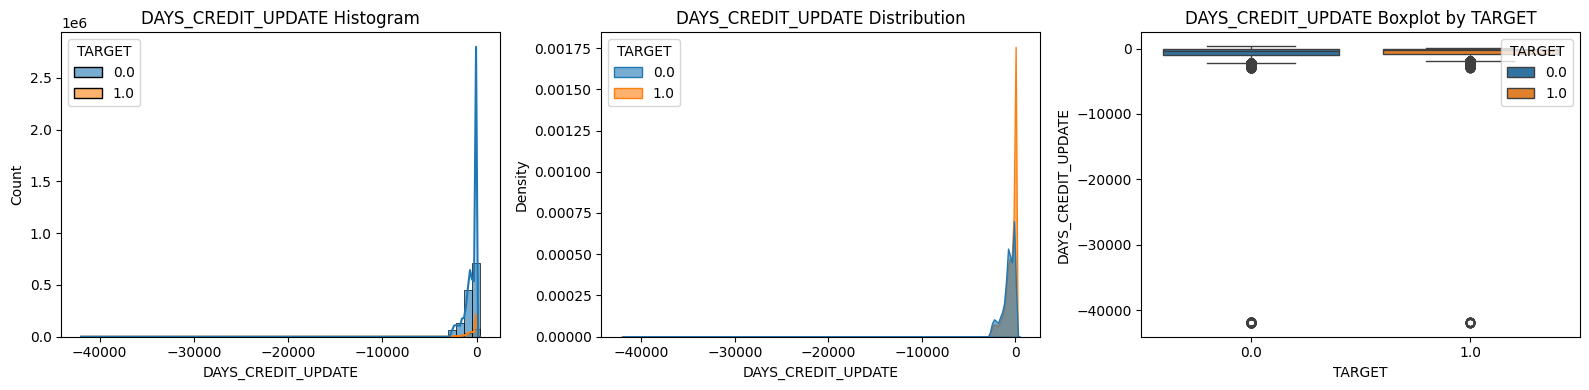

AMT_ANNUITY
count    489637.00
mean      15712.76
std      325826.95
min           0.00
1%            0.00
5%            0.00
25%           0.00
50%           0.00
75%       13500.00
95%       46571.40
99%      118451.88
max   118453423.50

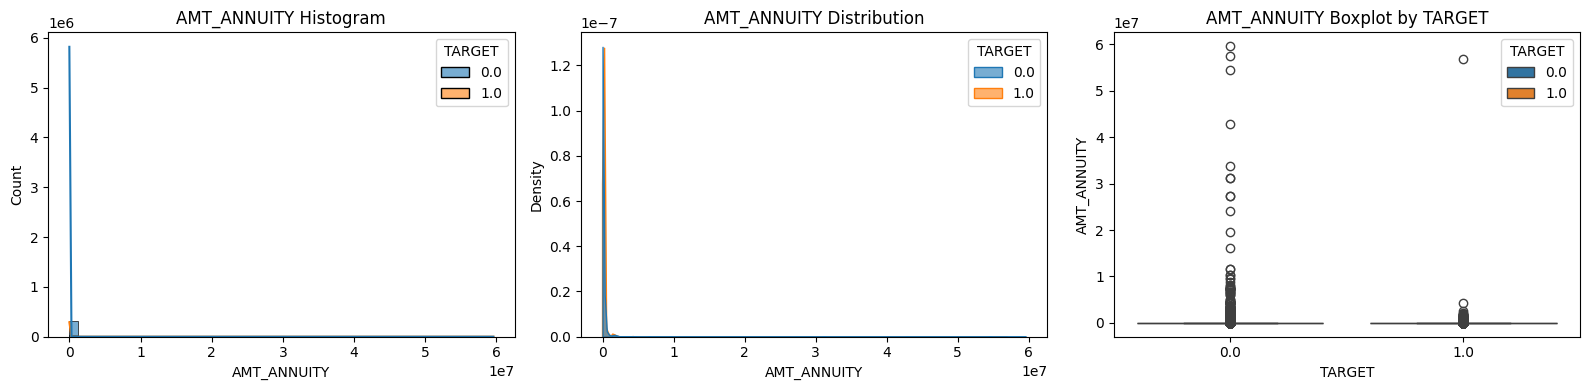

In [61]:
hist_boxplot_numeric_df(bureau_target)

In [120]:
gc.enable()
del bureau_target
gc.collect()

6522

CREDIT_DAY_OVERDUE: has several outlies and most values ​​are concentrated in 0, meaning the days of delinquency at the time of requesting the application are 0 days. We could transform it into a variable or categorical value, such as delinquency/non-delinquency or 0 days delinquent, 1-60 days delinquent, or +61 days delinquent.

DAYS_CREDIT_ENDDATE: also has several outlier values. We could limit and cap values ​​greater than 10 years to 10 years:
cap = 3650 # 10 years
bureau['DAYS_CREDIT_ENDDATE_capped'] = bureau['DAYS_CREDIT_ENDDATE'].clip(lower=-cap, upper=cap)
This is to avoid handling so many outliers for debts that are long overdue or were paid off a long time ago. For null values, we could leave it at 0, which represents the remaining duration at the time of the credit application = 0.

DAYS_ENDDATE_FACT: has few outliers. On the negative side, we could discard those negative outliers so that they are not included. It affects the data, but it has a high correlation with days_credit and around 35% missing values, so we can discard it.

AMT_CREDIT_MAX_OVERDUE: It has outliers and most values ​​are concentrated at 0, meaning the maximum amount overdue in the credit bureau as of the application date. We could transform it into a binary variable, maximum amount of 0 or different from 0, although it contains many missing values ​​according to missing_pct, so it will be discarded.

CNT_CREDIT_PROLONG: It indicates the number of times the loan was extended. We could make it binary: extended/not extended. However, we note that if it is extended more than 4 times there is no default, so we could set the categories: 0 extensions, 1 to 4 extensions, and 5+ extensions. This might be more convenient:

AMT_CREDIT_SUM: Current credit amount of any loan in the credit bureau. We could also categorize it as follows: loans between 0 and 250,000, from 250,001 to 500,000, and from 500,001 and up.

AMT_CREDIT_SUM_DEBT: Current debt amount in the credit bureau. We could categorize it as: 0 to 150,000, from 150,001 to 300,000, and 300,000 and up.

AMT_CREDIT_SUM_LIMIT: Since most of the data is 0, we could categorize it as: 0 to 250,000, 250,001 to 500,000, from 500,001 to 1,000,000, and from 1,000,000 and up. From now on

AMT_CREDIT_SUM_OVERDUE: Most values ​​are back to 0, almost all values, few outliers outside of 0. We could make it binary.

DAYS_CREDIT_UPDATE: Many negative outliers at the same point; suggest removing it.

AMT_ANNUITY: Remove it from the evaluation; it contains many missing values.

# bureau_balance

In [121]:
bureau_balance = pd.read_csv(r"home-credit-default-risk/bureau_balance.csv.gz", compression='gzip')
structural_summary(bureau_balance, "bureau_balance", key_cols=["SK_ID_BUREAU"])

dataset                      bureau_balance
rows                               27299925
columns                                   3
avg_missing (%)                        0.00
n_numeric                                 2
n_categorical                             1
n_bool                                    0
n_object                                  1
SK_ID_BUREAU__exists                   True
SK_ID_BUREAU__unique_rows             False
SK_ID_BUREAU__nulls                       0
dtype: object

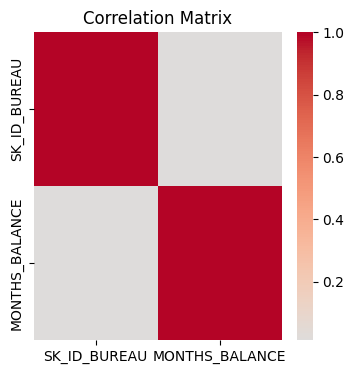


Pairs with |corr| > 0.8:
0 pairs found.
Empty DataFrame
Columns: [feature_1, feature_2, abs(corr)]
Index: []


In [122]:
correlation_redundancy(bureau_balance, threshold=0.8)

In [123]:
resumen_missing(bureau_balance)


Missing values in the DataFrame
No missing values


In [124]:
bureau_balance_bureau = bureau_balance.merge(
    bureau[['SK_ID_CURR', 'SK_ID_BUREAU']],
    on='SK_ID_BUREAU',
    how='left'
)

bureau_balance_target = applications[['SK_ID_CURR', 'TARGET']].merge(
    bureau_balance_bureau,
    on='SK_ID_CURR',
    how='left'
)

correlation_target(bureau_balance_target)

Top 10 correlations with TARGET:



MONTHS_BALANCE    0.03
SK_ID_BUREAU     -0.01
SK_ID_CURR        0.00
Name: TARGET, dtype: float64

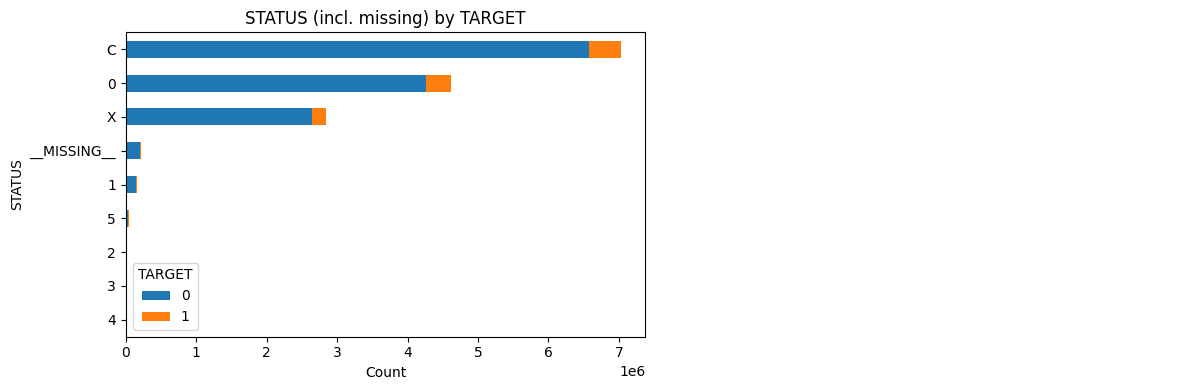

In [70]:
multi_stack_plot(bureau_balance_target, bureau_balance_target.select_dtypes(include=["object"]).columns)

MONTHS_BALANCE
count     14701612.00
mean           -28.63
std             22.07
min            -96.00
1%             -85.00
5%             -73.00
25%            -43.00
50%            -24.00
75%            -10.00
95%             -2.00
99%              0.00
max              0.00

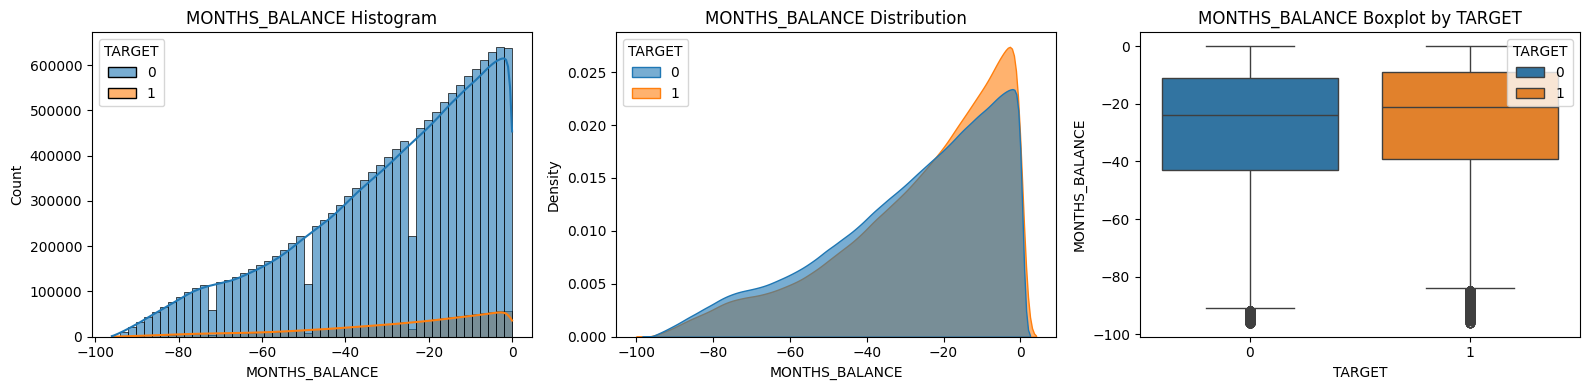

In [71]:
hist_boxplot_numeric_df(bureau_balance_target)

In [125]:
gc.enable()
del bureau_balance_target, bureau_balance, bureau_balance_bureau
gc.collect()

gc.enable()
del bureau
gc.collect()

0

# POS_CASH_balance

In [127]:
POS_CASH_balance = pd.read_csv(r"home-credit-default-risk/POS_CASH_balance.csv.gz", compression='gzip')
structural_summary(POS_CASH_balance, "POS_CASH_balance", key_cols=["SK_ID_PREV","SK_ID_CURR"])

dataset                    POS_CASH_balance
rows                               10001358
columns                                   8
avg_missing (%)                        0.07
n_numeric                                 7
n_categorical                             1
n_bool                                    0
n_object                                  1
SK_ID_PREV__exists                     True
SK_ID_PREV__unique_rows               False
SK_ID_PREV__nulls                         0
SK_ID_CURR__exists                     True
SK_ID_CURR__unique_rows               False
SK_ID_CURR__nulls                         0
dtype: object

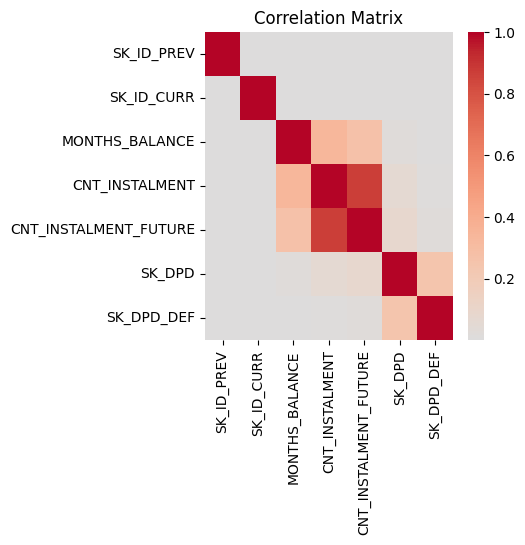


Pairs with |corr| > 0.8:
1 pairs found.
         feature_1              feature_2  abs(corr)
15  CNT_INSTALMENT  CNT_INSTALMENT_FUTURE       0.87


In [128]:
correlation_redundancy(POS_CASH_balance, threshold=0.8)

In [129]:
resumen_missing(POS_CASH_balance)


Missing values in the DataFrame
                       missing_count  missing_pct
CNT_INSTALMENT                 26071         0.26
CNT_INSTALMENT_FUTURE          26087         0.26


In [130]:
POS_CASH_balance_target = POS_CASH_balance.merge(
    applications[['SK_ID_CURR', 'TARGET']],
    on='SK_ID_CURR',
    how='left'
)

correlation_target(POS_CASH_balance_target)

Top 10 correlations with TARGET:



CNT_INSTALMENT_FUTURE    0.02
MONTHS_BALANCE           0.02
CNT_INSTALMENT           0.02
SK_DPD                   0.01
SK_DPD_DEF               0.01
SK_ID_CURR              -0.00
SK_ID_PREV              -0.00
Name: TARGET, dtype: float64

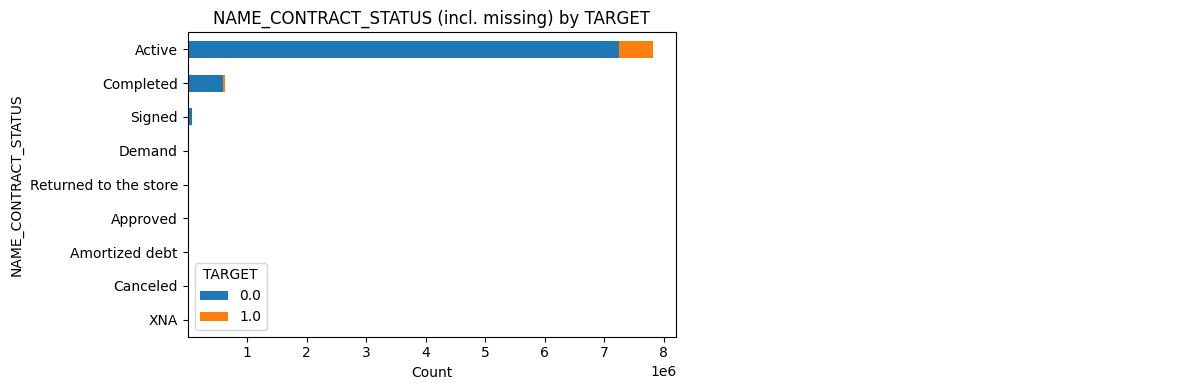

In [77]:
multi_stack_plot(POS_CASH_balance_target, POS_CASH_balance_target.select_dtypes(include=["object"]).columns)

MONTHS_BALANCE
count     10001358.00
mean           -35.01
std             26.07
min            -96.00
1%             -94.00
5%             -85.00
25%            -54.00
50%            -28.00
75%            -13.00
95%             -4.00
99%             -2.00
max             -1.00

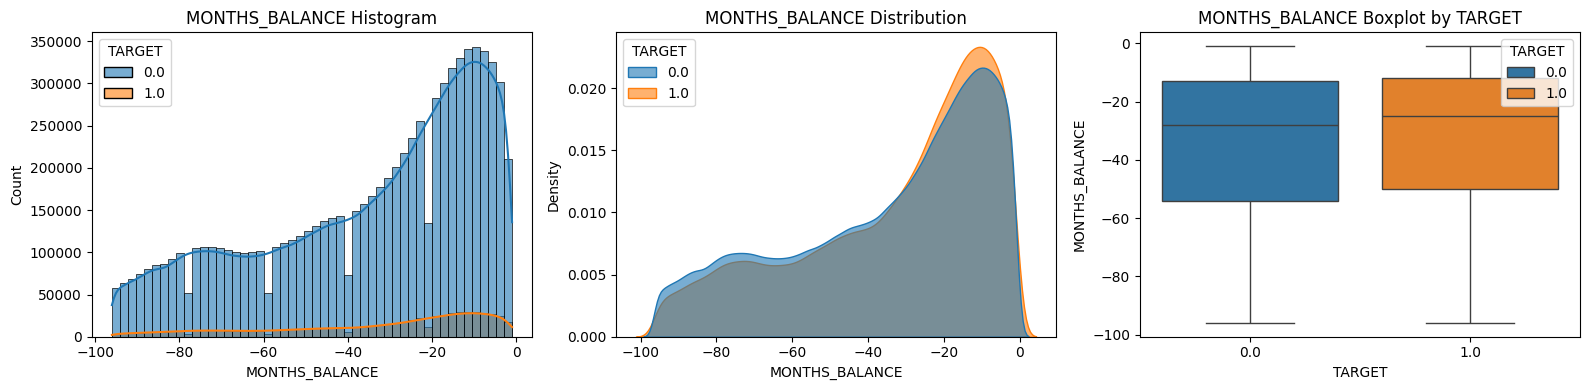

CNT_INSTALMENT
count      9975287.00
mean            17.09
std             12.00
min              1.00
1%               4.00
5%               6.00
25%             10.00
50%             12.00
75%             24.00
95%             45.00
99%             60.00
max             92.00

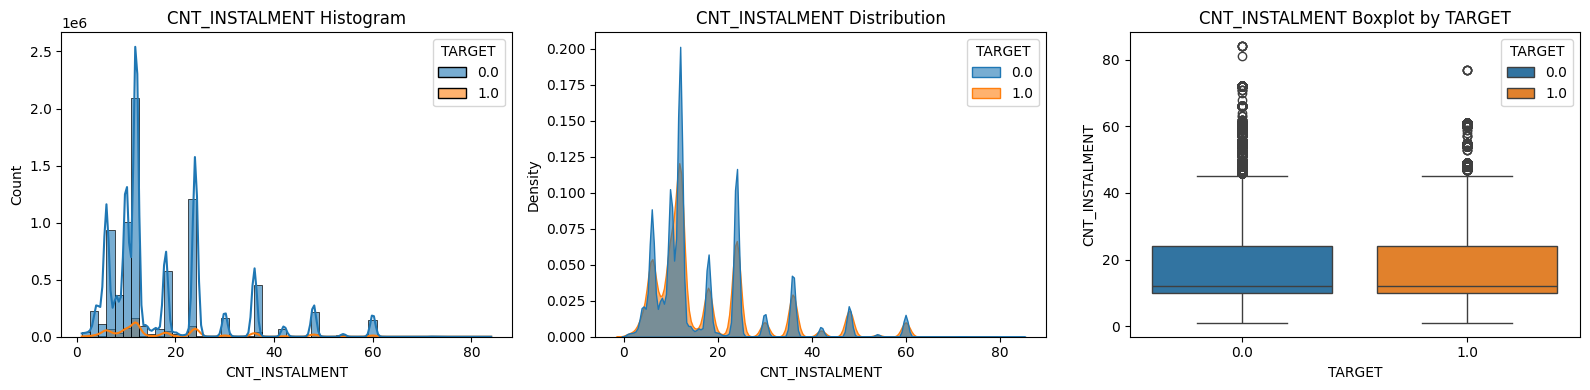

CNT_INSTALMENT_FUTURE
count             9975271.00
mean                   10.48
std                    11.11
min                     0.00
1%                      0.00
5%                      0.00
25%                     3.00
50%                     7.00
75%                    14.00
95%                    35.00
99%                    53.00
max                    85.00

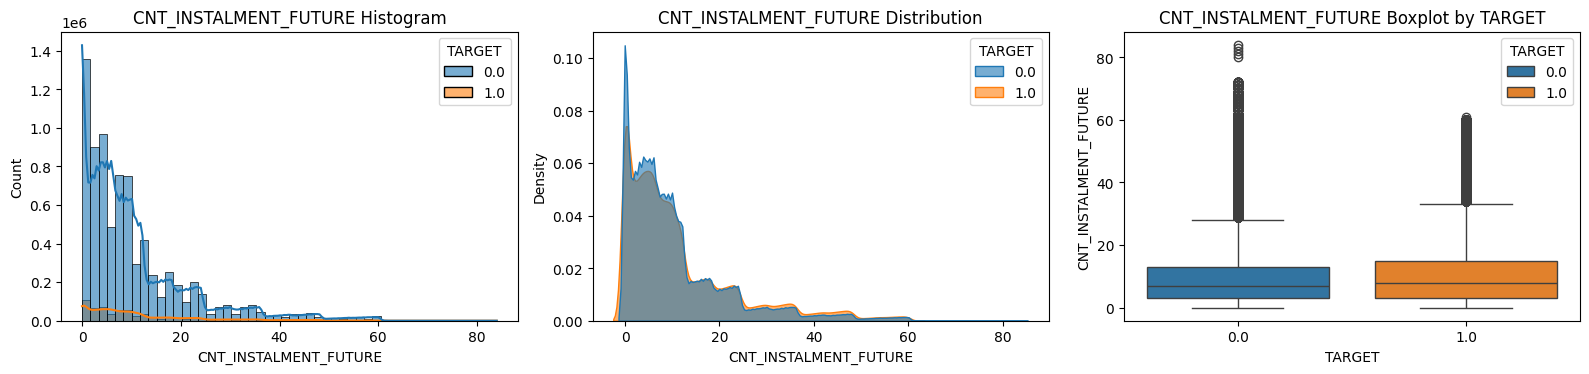

In [78]:
hist_boxplot_numeric_df(POS_CASH_balance_target)

In [131]:
gc.enable()
del POS_CASH_balance_target, POS_CASH_balance
gc.collect()

5041

# previous_application

In [88]:
previous_application = pd.read_csv(r"home-credit-default-risk/previous_application.csv.gz", compression='gzip')
structural_summary(previous_application, "previous_application", key_cols=["SK_ID_PREV", "SK_ID_CURR"])

dataset                    previous_application
rows                                    1670214
columns                                      37
avg_missing (%)                           17.98
n_numeric                                    21
n_categorical                                16
n_bool                                        0
n_object                                     16
SK_ID_PREV__exists                         True
SK_ID_PREV__unique_rows                    True
SK_ID_PREV__nulls                             0
SK_ID_CURR__exists                         True
SK_ID_CURR__unique_rows                   False
SK_ID_CURR__nulls                             0
dtype: object

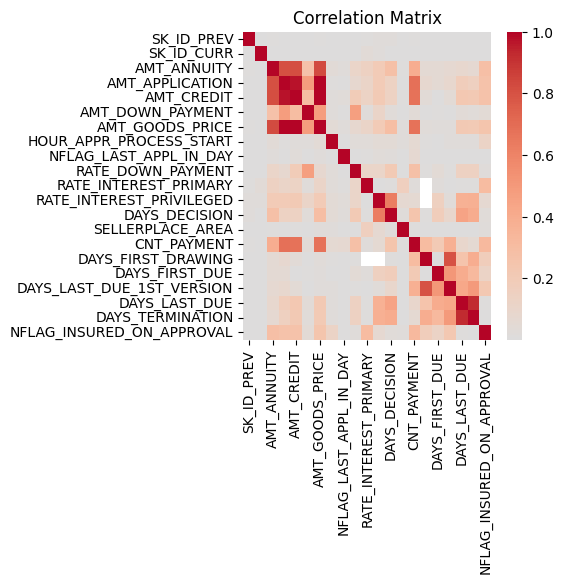


Pairs with |corr| > 0.8:
8 pairs found.
              feature_1                  feature_2  abs(corr)
59      AMT_APPLICATION            AMT_GOODS_PRICE       1.00
75           AMT_CREDIT            AMT_GOODS_PRICE       0.99
57      AMT_APPLICATION                 AMT_CREDIT       0.98
205       DAYS_LAST_DUE           DAYS_TERMINATION       0.93
42          AMT_ANNUITY            AMT_GOODS_PRICE       0.82
40          AMT_ANNUITY                 AMT_CREDIT       0.82
39          AMT_ANNUITY            AMT_APPLICATION       0.81
194  DAYS_FIRST_DRAWING  DAYS_LAST_DUE_1ST_VERSION       0.80


In [ ]:
correlation_redundancy(previous_application, threshold=0.8)

In [102]:
resumen_missing(previous_application)


Missing values in the DataFrame
                           missing_count  missing_pct
RATE_INTEREST_PRIVILEGED         1664263        99.64
RATE_INTEREST_PRIMARY            1664263        99.64
AMT_DOWN_PAYMENT                  895844        53.64
RATE_DOWN_PAYMENT                 895844        53.64
NAME_TYPE_SUITE                   820405        49.12
DAYS_LAST_DUE                     673065        40.30
DAYS_FIRST_DRAWING                673065        40.30
DAYS_FIRST_DUE                    673065        40.30
DAYS_TERMINATION                  673065        40.30
NFLAG_INSURED_ON_APPROVAL         673065        40.30
DAYS_LAST_DUE_1ST_VERSION         673065        40.30
AMT_GOODS_PRICE                   385515        23.08
CNT_PAYMENT                       372230        22.29
AMT_ANNUITY                       372235        22.29
PRODUCT_COMBINATION                  346         0.02


In [83]:
previous_application_target = previous_application.merge(
    applications[['SK_ID_CURR', 'TARGET']],
    on='SK_ID_CURR',
    how='left'
)

correlation_target(previous_application_target)

Top 10 correlations with TARGET:



DAYS_DECISION                0.04
DAYS_FIRST_DRAWING          -0.03
CNT_PAYMENT                  0.03
RATE_INTEREST_PRIVILEGED     0.03
HOUR_APPR_PROCESS_START     -0.03
RATE_DOWN_PAYMENT           -0.03
DAYS_LAST_DUE_1ST_VERSION    0.02
DAYS_LAST_DUE                0.02
DAYS_TERMINATION             0.02
AMT_DOWN_PAYMENT            -0.02
Name: TARGET, dtype: float64

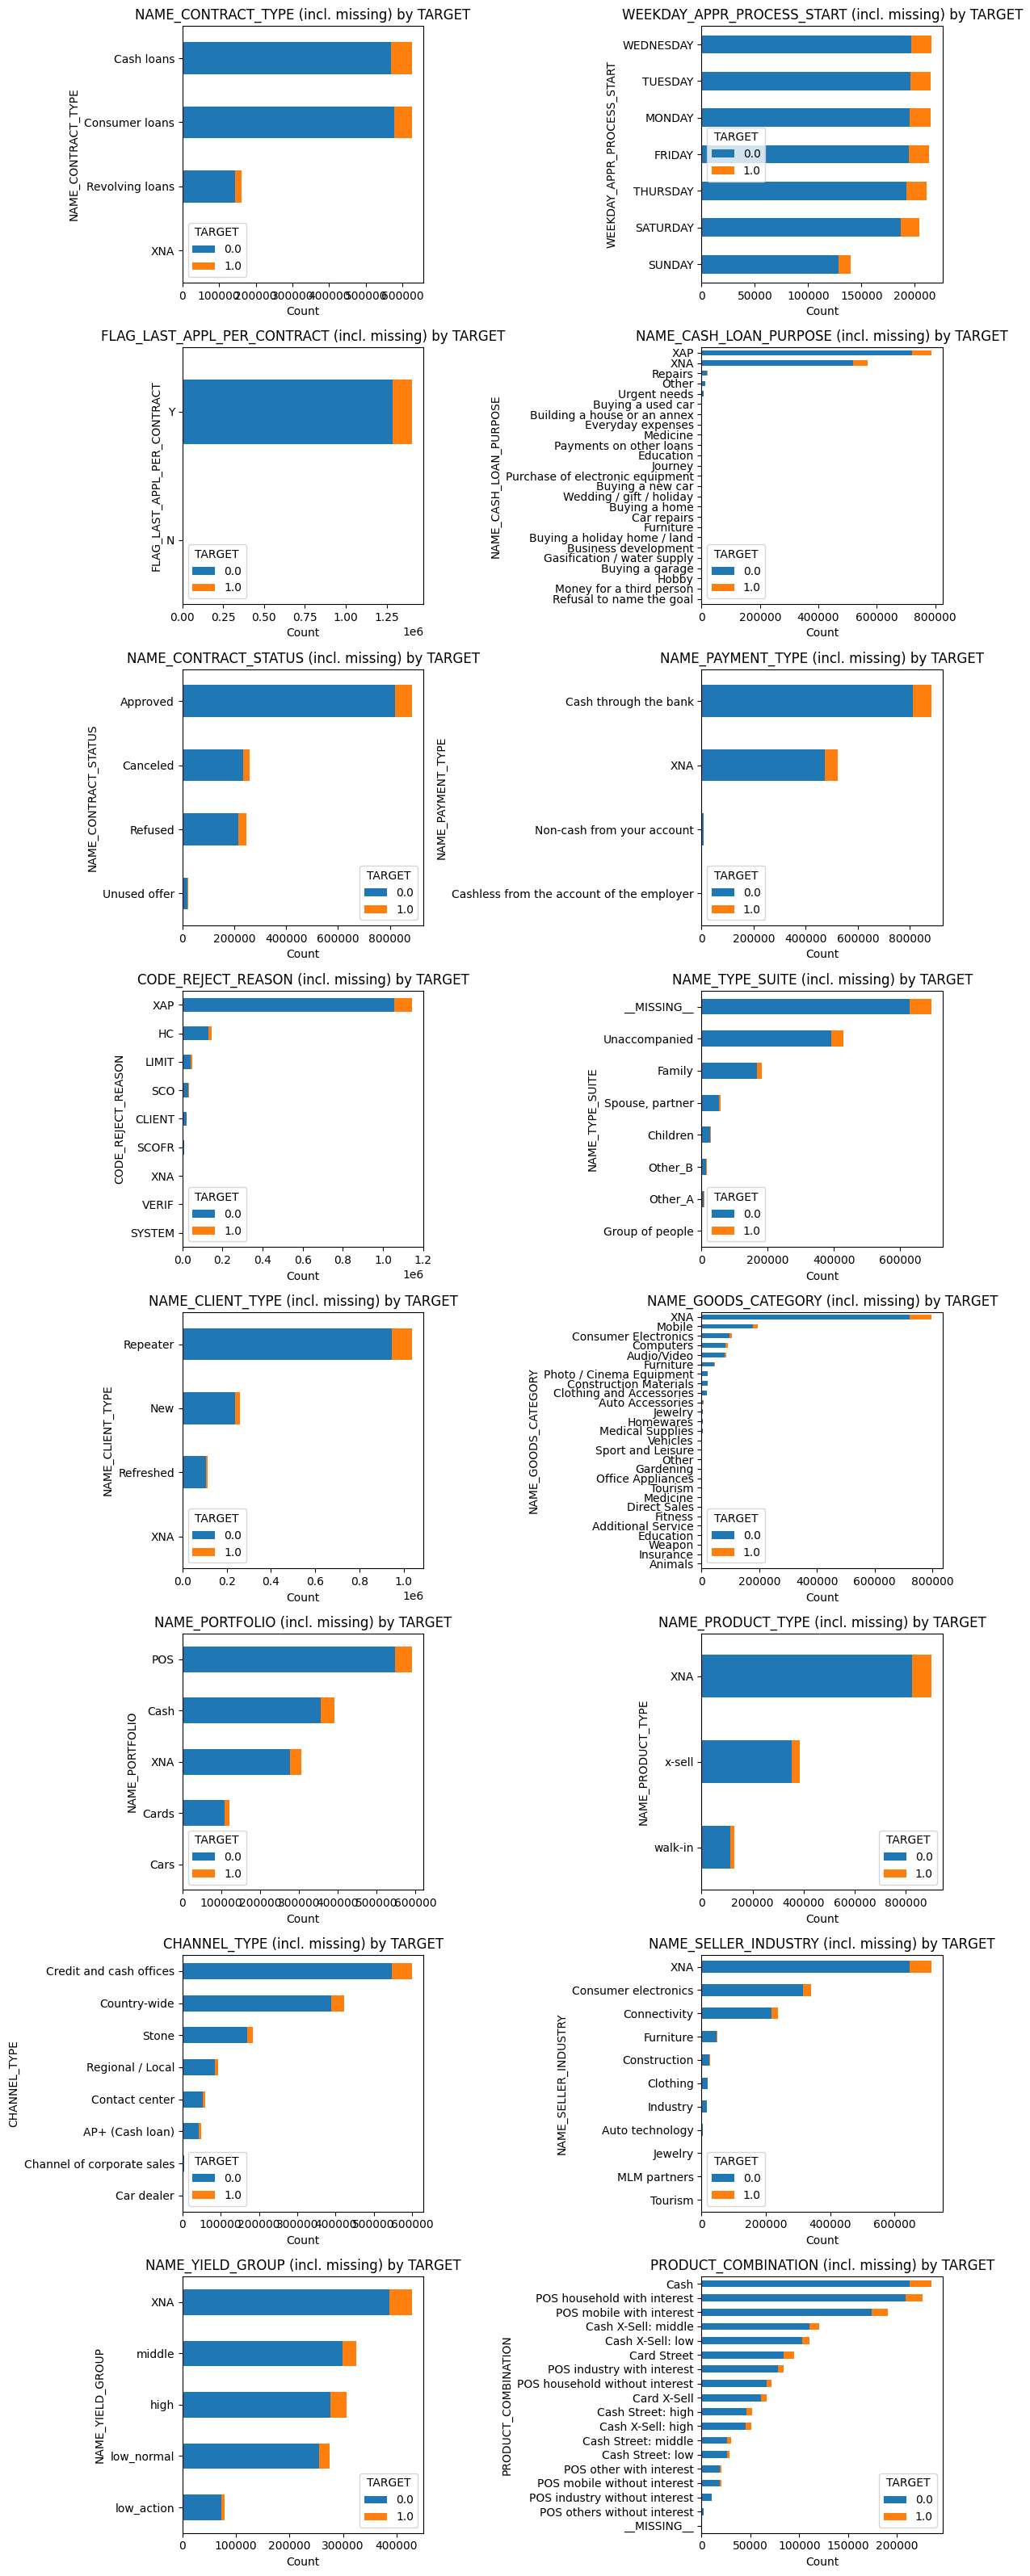

In [84]:
multi_stack_plot(previous_application_target, previous_application_target.select_dtypes(include=["object"]).columns)

AMT_ANNUITY
count   1297979.00
mean      15955.12
std       14782.14
min           0.00
1%         2137.18
5%         2726.59
25%        6321.78
50%       11250.00
75%       20658.42
95%       45336.78
99%       69685.79
max      418058.15

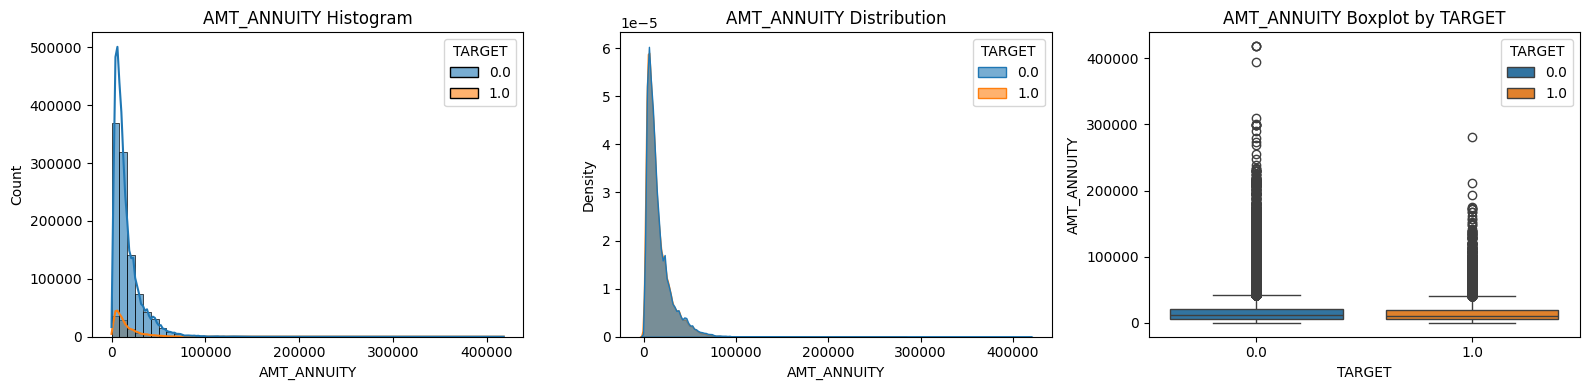

AMT_APPLICATION
count       1670214.00
mean         175233.86
std          292779.76
min               0.00
1%                0.00
5%                0.00
25%           18720.00
50%           71046.00
75%          180360.00
95%          787500.00
99%         1350000.00
max         6905160.00

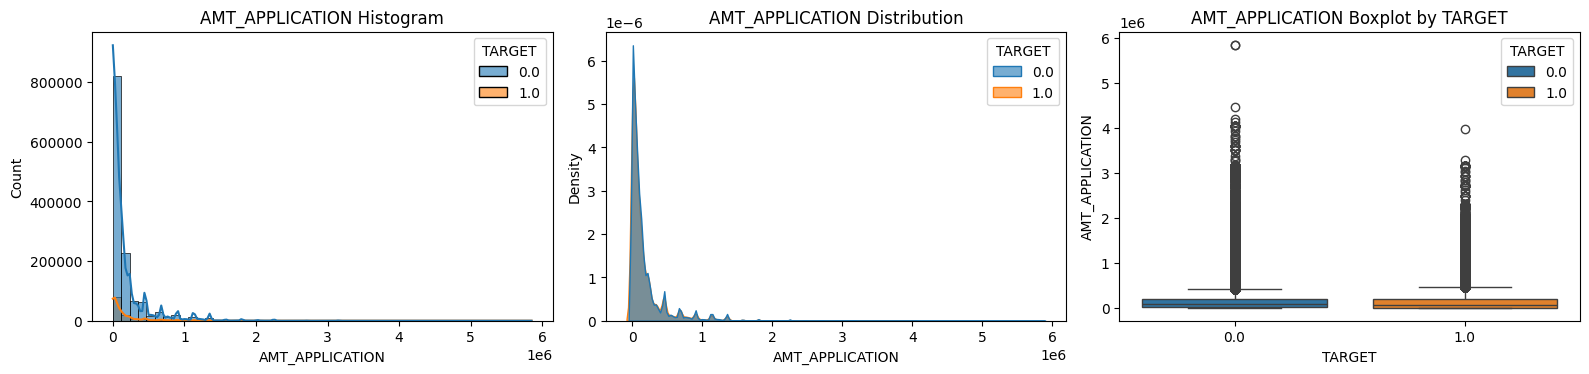

AMT_CREDIT
count  1670213.00
mean    196114.02
std     318574.62
min          0.00
1%           0.00
5%           0.00
25%      24160.50
50%      80541.00
75%     216418.50
95%     886500.00
99%    1515377.70
max    6905160.00

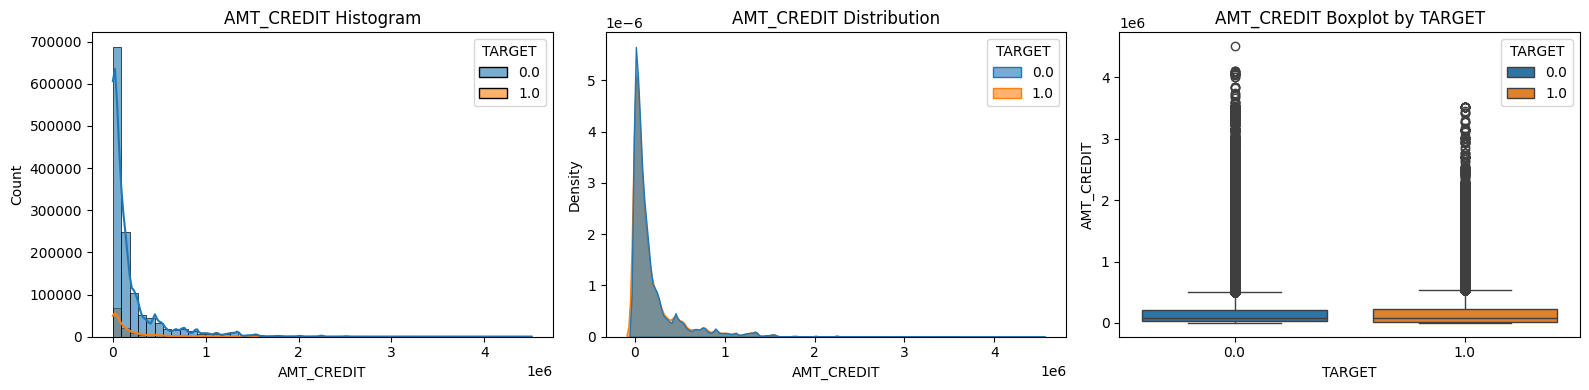

AMT_DOWN_PAYMENT
count         774370.00
mean            6697.40
std            20921.50
min               -0.90
1%                 0.00
5%                 0.00
25%                0.00
50%             1638.00
75%             7740.00
95%            26184.08
99%            65930.89
max          3060045.00

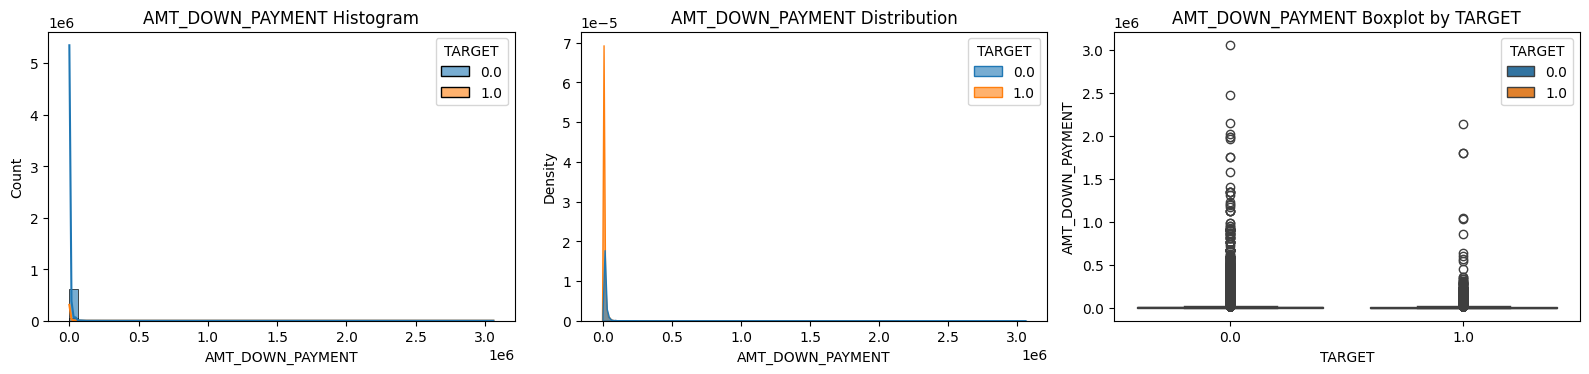

AMT_GOODS_PRICE
count       1284699.00
mean         227847.28
std          315396.56
min               0.00
1%            15300.00
5%            22882.50
25%           50841.00
50%          112320.00
75%          234000.00
95%          900000.00
99%         1395000.00
max         6905160.00

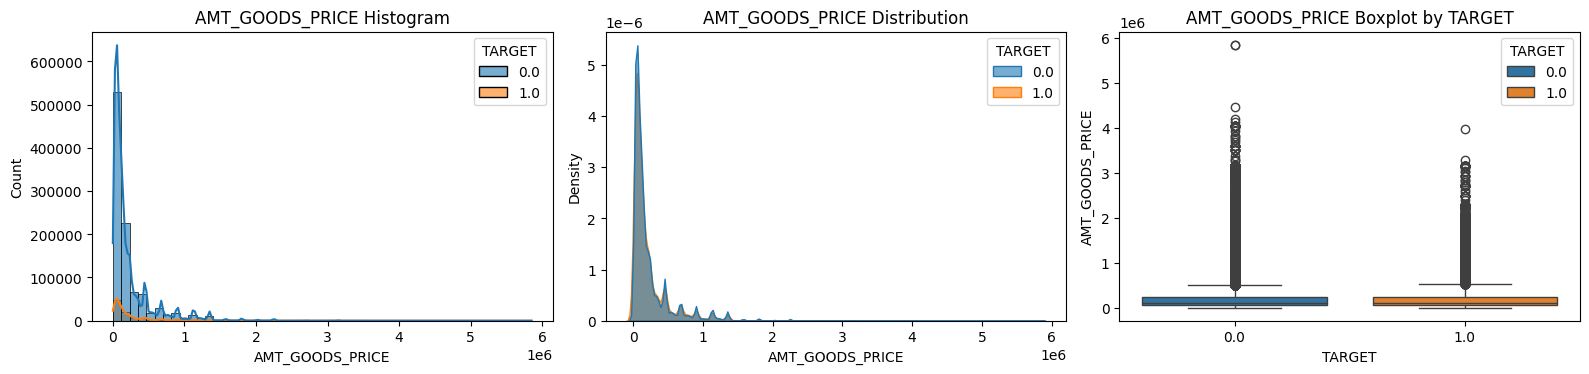

HOUR_APPR_PROCESS_START
count               1670214.00
mean                     12.48
std                       3.33
min                       0.00
1%                        5.00
5%                        7.00
25%                      10.00
50%                      12.00
75%                      15.00
95%                      18.00
99%                      20.00
max                      23.00

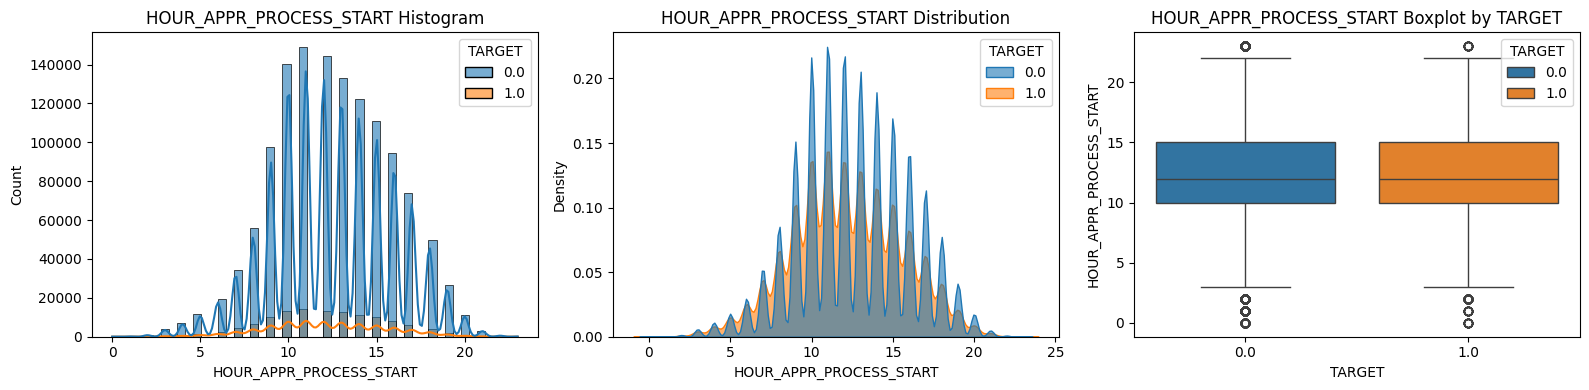

NFLAG_LAST_APPL_IN_DAY
count              1670214.00
mean                     1.00
std                      0.06
min                      0.00
1%                       1.00
5%                       1.00
25%                      1.00
50%                      1.00
75%                      1.00
95%                      1.00
99%                      1.00
max                      1.00

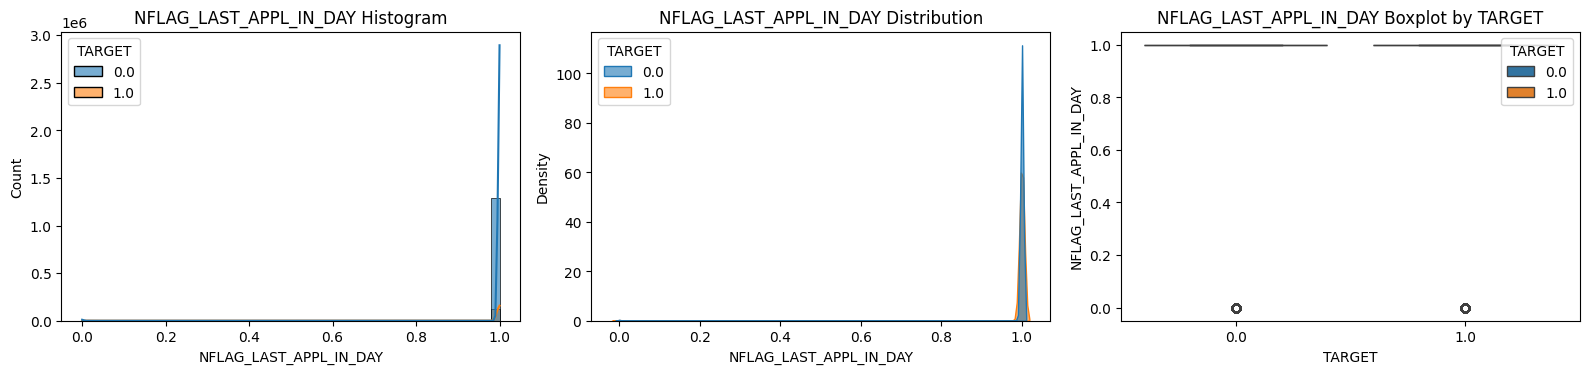

RATE_DOWN_PAYMENT
count          774370.00
mean                0.08
std                 0.11
min                -0.00
1%                  0.00
5%                  0.00
25%                 0.00
50%                 0.05
75%                 0.11
95%                 0.29
99%                 0.52
max                 1.00

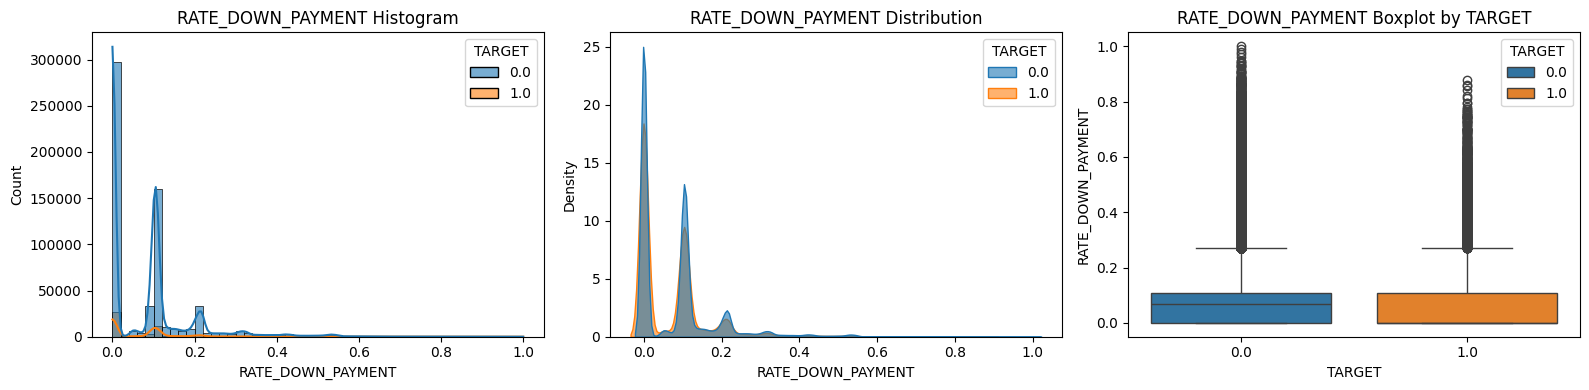

RATE_INTEREST_PRIMARY
count                5951.00
mean                    0.19
std                     0.09
min                     0.03
1%                      0.06
5%                      0.14
25%                     0.16
50%                     0.19
75%                     0.19
95%                     0.20
99%                     0.70
max                     1.00

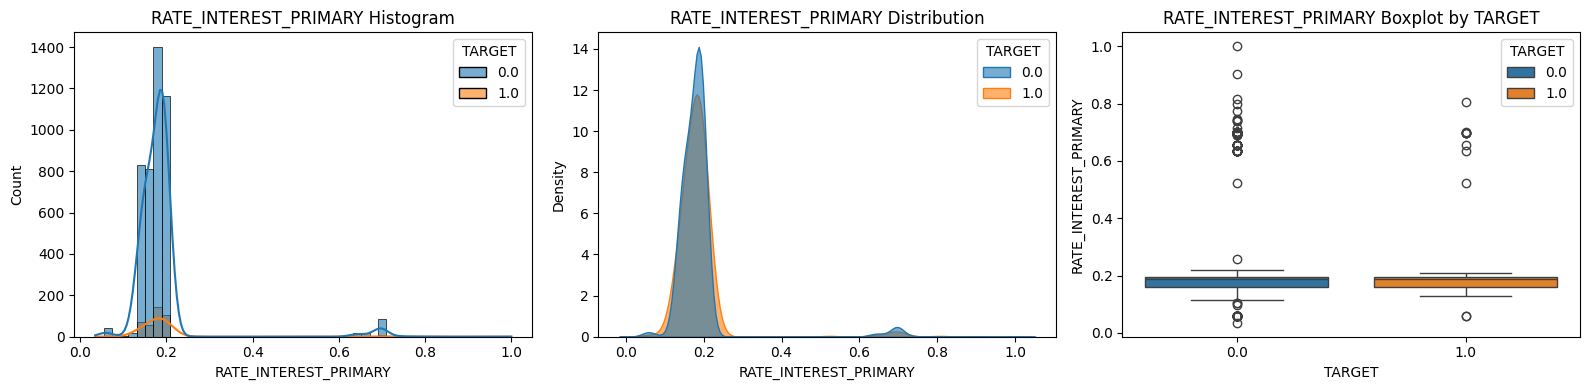

RATE_INTEREST_PRIVILEGED
count                   5951.00
mean                       0.77
std                        0.10
min                        0.37
1%                         0.42
5%                         0.64
25%                        0.72
50%                        0.84
75%                        0.85
95%                        0.87
99%                        0.87
max                        1.00

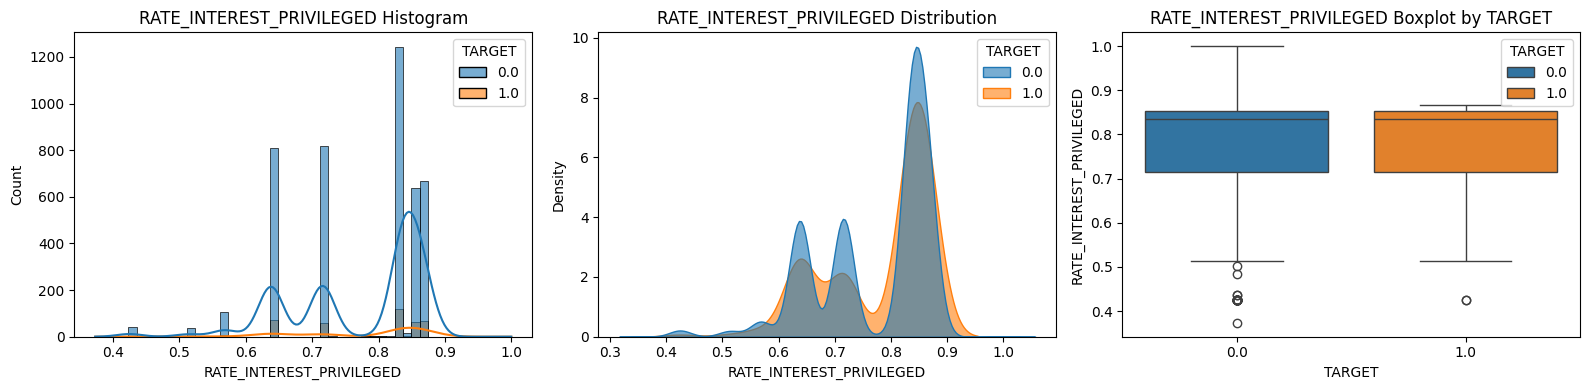

DAYS_DECISION
count     1670214.00
mean         -880.68
std           779.10
min         -2922.00
1%          -2835.00
5%          -2559.00
25%         -1300.00
50%          -581.00
75%          -280.00
95%           -85.00
99%           -14.00
max            -1.00

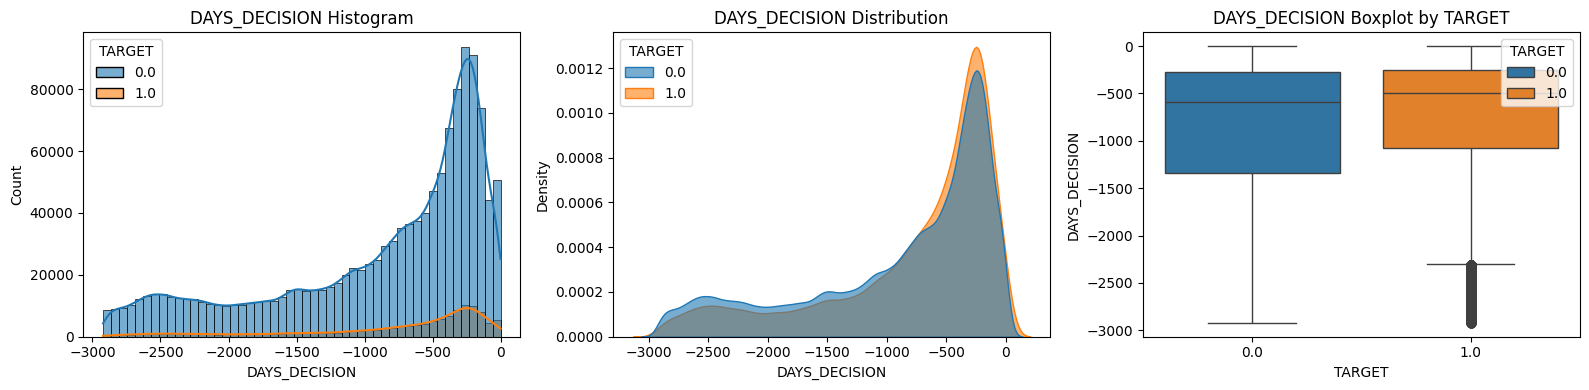

SELLERPLACE_AREA
count        1670214.00
mean             313.95
std             7127.44
min               -1.00
1%                -1.00
5%                -1.00
25%               -1.00
50%                3.00
75%               82.00
95%             1820.00
99%             3570.00
max          4000000.00

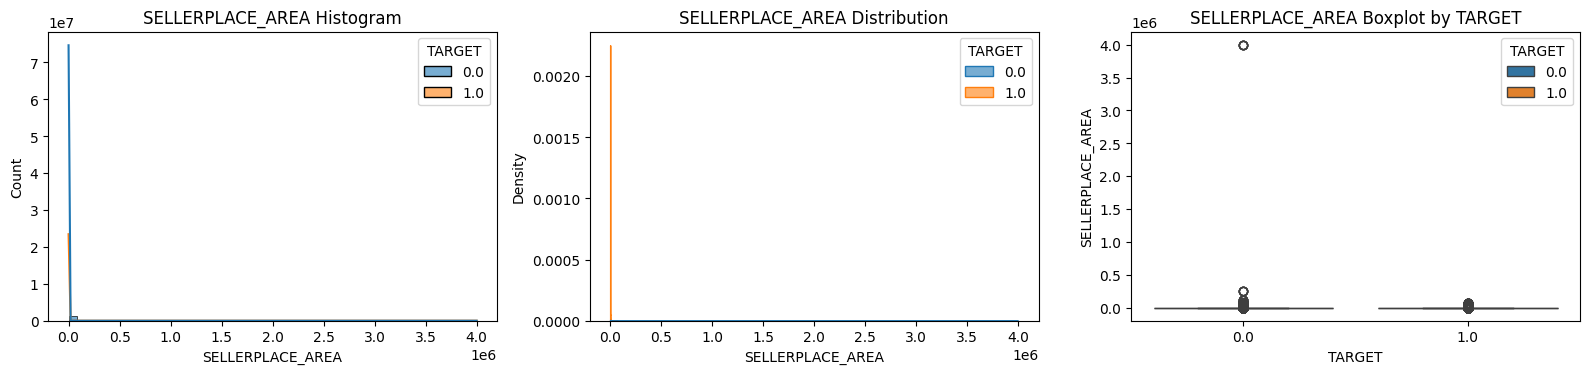

CNT_PAYMENT
count   1297984.00
mean         16.05
std          14.57
min           0.00
1%            0.00
5%            0.00
25%           6.00
50%          12.00
75%          24.00
95%          48.00
99%          60.00
max          84.00

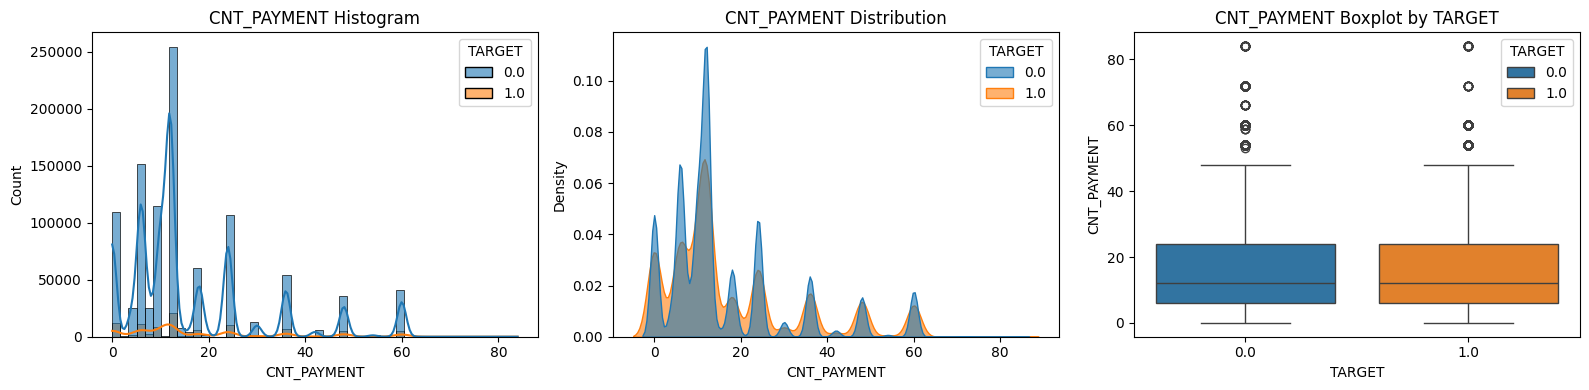

DAYS_FIRST_DRAWING
count           997149.00
mean            342209.86
std              88916.12
min              -2922.00
1%               -2441.00
5%                -269.00
25%             365243.00
50%             365243.00
75%             365243.00
95%             365243.00
99%             365243.00
max             365243.00

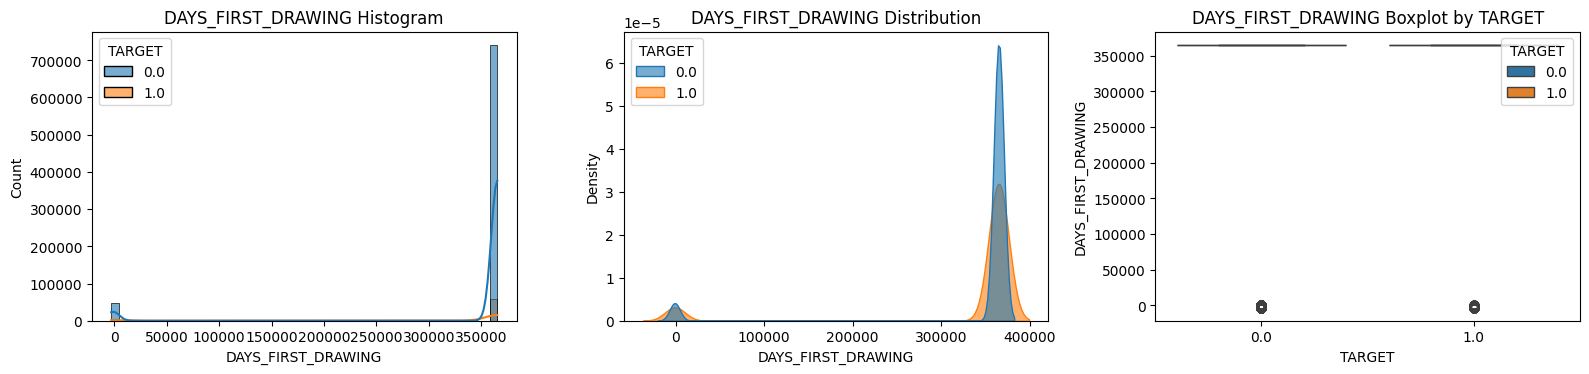

DAYS_FIRST_DUE
count       997149.00
mean         13826.27
std          72444.87
min          -2892.00
1%           -2822.00
5%           -2608.00
25%          -1628.00
50%           -831.00
75%           -411.00
95%            -48.00
99%         365243.00
max         365243.00

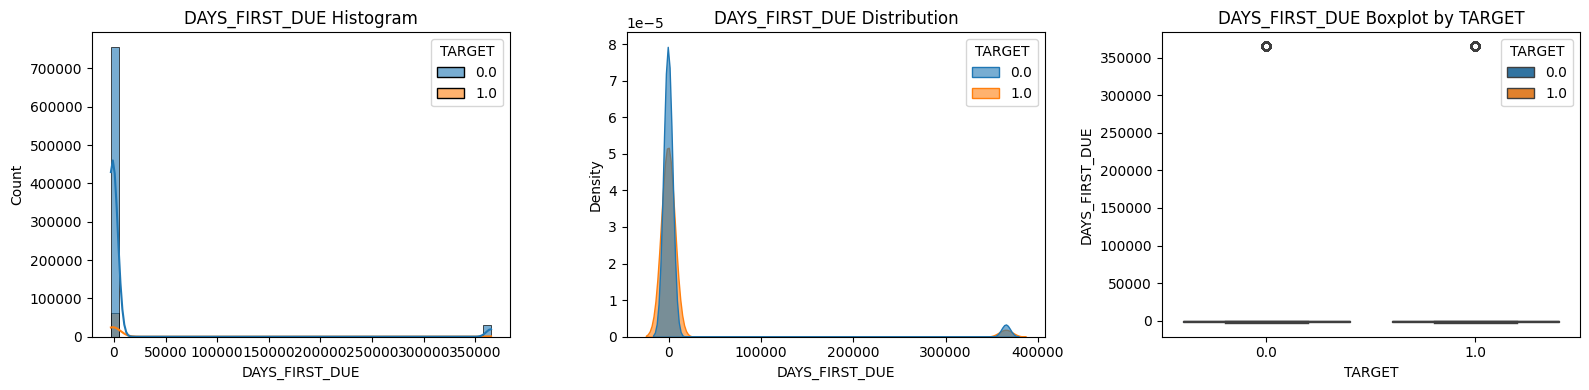

DAYS_LAST_DUE_1ST_VERSION
count                  997149.00
mean                    33767.77
std                    106857.03
min                     -2801.00
1%                      -2599.00
5%                      -2327.00
25%                     -1242.00
50%                      -361.00
75%                       129.00
95%                    365243.00
99%                    365243.00
max                    365243.00

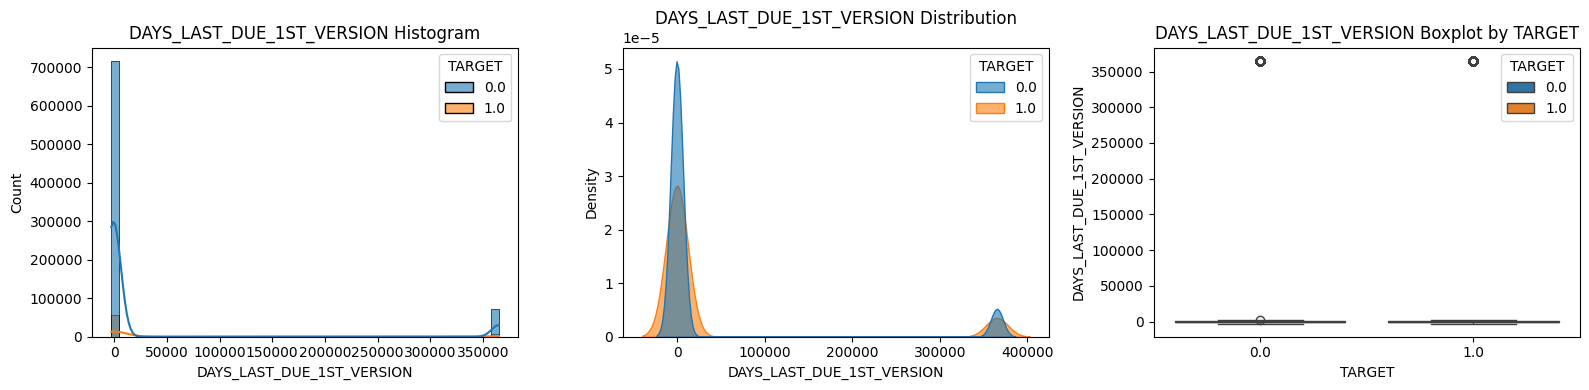

DAYS_LAST_DUE
count      997149.00
mean        76582.40
std        149647.42
min         -2889.00
1%          -2618.00
5%          -2349.00
25%         -1314.00
50%          -537.00
75%           -74.00
95%        365243.00
99%        365243.00
max        365243.00

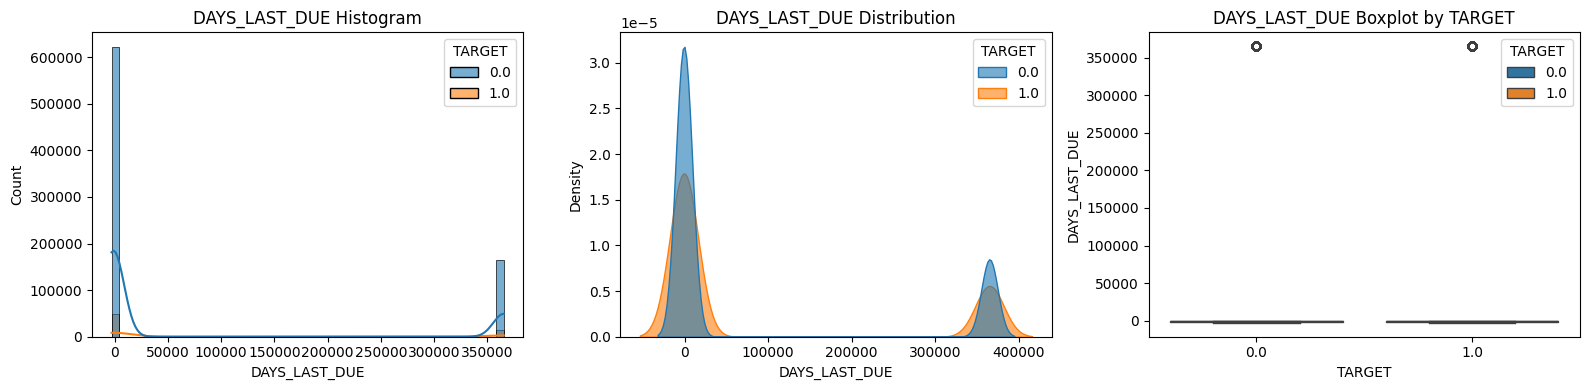

DAYS_TERMINATION
count         997149.00
mean           81992.34
std           153303.52
min            -2874.00
1%             -2589.00
5%             -2331.00
25%            -1270.00
50%             -499.00
75%              -44.00
95%           365243.00
99%           365243.00
max           365243.00

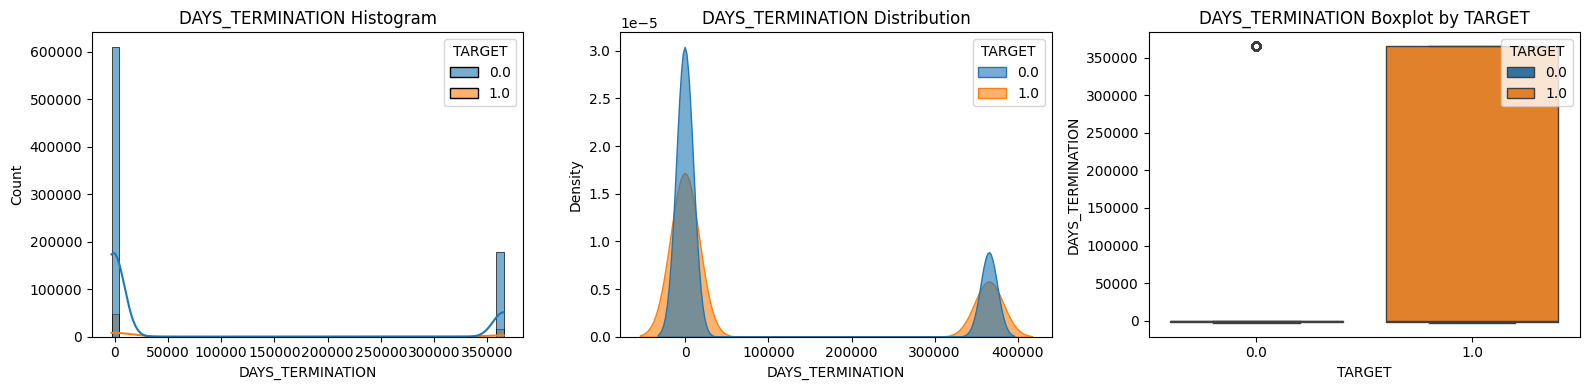

NFLAG_INSURED_ON_APPROVAL
count                  997149.00
mean                        0.33
std                         0.47
min                         0.00
1%                          0.00
5%                          0.00
25%                         0.00
50%                         0.00
75%                         1.00
95%                         1.00
99%                         1.00
max                         1.00

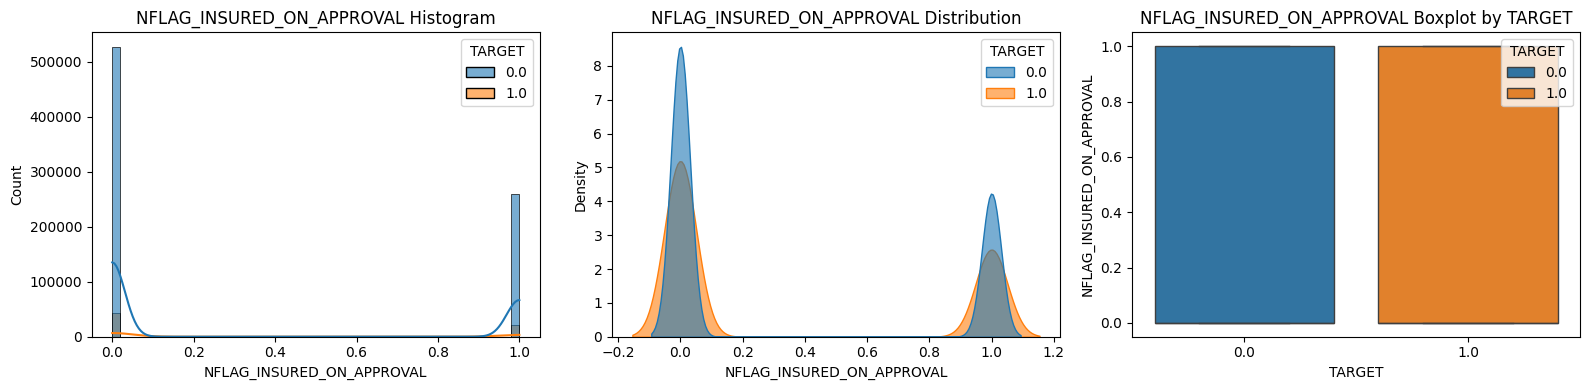

In [85]:
hist_boxplot_numeric_df(previous_application_target)

In [ ]:
gc.enable()
del previous_application_target, previous_application
gc.collect()

484

From the name contract type field, we can remove XNA (potential noise).

The week_appr_process_start field doesn't show much variance between days except for Sunday (I assume people don't usually apply for loans on Sundays), (possible exclusion from evaluation).

The flag_last..._contract field doesn't provide any information about payments, income, late payments, credit history, etc. It only addresses an operational issue (errors or duplicates); it's just a flag, meaning we shouldn't consider it for evaluation.

name_cash_loan_purpose: It appears to have multiple options and little variance; however, many are XNA or XAP, so it can also be downloaded for evaluation since most of the purposes are unknown.

name_contract_status looks good. Contract status (approved, cancelled, ...) of previous application.

NAME_PAYMENT_TYPE: The payment method used by the client for the previous application. Again, there is a lot of data in XNA, so we can discard it for evaluation.

CODE_REJECT_REASON: It looks good; we could remove XNA.

NAME_TYPE_SUITE: Indicates who accompanied the applicant when requesting the previous application; it can be discarded for evaluation.

NAME_CLIENT_TYPE: Indicates whether the client is old or new for the previous application; remove only XNA.

NAME_GOODS_CATEGORY: Most are unknown; we can discard it all. It is not important for evaluation. Most of the data comes from XNA.

NAME_PORTFOLIO: Leave this variable as it indicates the type of previous application. Regarding XNA, it has a significant number of values, so it will be retained for this case.

NAME_PRODUCT_TYPE: This also has several XNA values ​​and indicates whether the previous application was cross-selling or walk-in (i.e., cross-selling, active offering, or customer-initiated). This data could be useful.

Channel_ttype: Looks good.

SELLERPLACE_AREA: Most are XNA. We can discard this metric. It indicates the seller's industry.

NAME_YIELD_GROUP: Indicates the interest percentage group of the previous customer application (low, normal, or high). However, it has many XNA values, so caution is advised.

PRODUCT_COMBINATION: Appears to have a good distribution.

# Categorical Summary:

(bureau):

CREDIT_CURRENCY: Transform currency 1 / other currencies

CREDIT_TYPE: Keep the top 5 types and leave the others as "other"

(bureau_balance):

STATUS: Combine 1 = 1-60 days, 2 = 61-120 days, 3 = +120 days

(POS_CASH_balance)

NAME_CONTRACT_STATUS: Remove XNA's

(previous_application)

NAME_CONTRACT_TYPE: Remove XNA

WEEKDAY_APPR_PROCESS_START: Discard metric

FLAG_LAST_APPL_PER_CONTRACT: Discard metric

NAME_CASH_LOAN_PURPOSE: Discard metric

NAME_PAYMENT_TYPE: Discard metric

CODE_REJECT_REASON: Remove XNA

NAME_TYPE_SUITE: Discard metric

NAME_CLIENT_TYPE: Remove XNA

NAME_GOODS_CATEGORY: Discard metric

name_portfolio: Keep metric, warning: many XNA

NAME_PRODUCT_TYPE: Keep metric, warning: many XNA

NAME_SELLER_INDUSTRY: Discard metric

NAME_YIELD_GROUP: Keep metric, warning: many XNA